# Affective User Research Seminar

In diesem Jupyter Notebook analysieren wir einen Datensatz, der Nutzerdaten aus Interaktionen zwischen Nutzern und einem Chat-Assistenten enthält. Unser Ziel ist es, zwei wesentliche Fragen zu untersuchen:

1. **Einfluss der Nutzereigenschaften auf die emotionale Bewertung:**
   - Wie beeinflussen erfasste Nutzereigenschaften wie Vorerfahrungen, Geschlecht, Alter und Vertrauen in den Assistenten die emotionale Bewertung der Interaktion durch den Nutzer sowie Confidence und Understanding Werte? Die emotionale Bewertung erfolgte anhand der Valence- und Arousal-Skala.

2. **Einfluss des Prompting-Verhaltens und der Interaktionsdaten auf die emotionale Bewertung:**
   - Welchen Einfluss hat das Verhalten der Nutzer bei der Eingabe von Prompts sowie die unmittelbaren Interaktionsdaten auf die emotionale Bewertung der Interaktion?

## Vorgehensweise

- **Datenbereinigung:** Wir haben die Daten gesichtet und bereinigt.
- **Zielvariable:** Definiert wurde eine 4-Klassen-Zielvariable, die die emotionale Bewertung in vier Kategorien unterteilt:
  - Hohe Valenz und hohes Arousal
  - Hohe Valenz und niedriges Arousal
  - Niedrige Valenz und niedriges Arousal
  - Niedrige Valenz und hohes Arousal

- **Feature Engineering:** Zusätzliche Merkmale aus den Interaktionsdaten wurden extrahiert.
- **User Clustering:** Ein Clustering der Nutzer wurde durchgeführt.
- **Modelltraining und -bewertung:** Verschiedene Modelle wurden trainiert und bewertet.

## Ergebnisse

Trotz umfassender Modellierung und Hyperparameter-Tuning kamen wir zu dem Ergebnis, dass die Modelle letztendlich keine signifikante Aussagekraft über das User-Sentiment liefern konnten. Weder die Nutzercluster noch die extrahierten Features hatten einen nennenswerten Einfluss auf die Vorhersage der emotionalen Bewertung. Diese Erkenntnisse legen nahe, dass die verfügbaren Daten möglicherweise nicht ausreichend sind, um präzise Vorhersagen über das User-Sentiment zu treffen.


# Import relevanter Klassen/Methoden/Funktionen

In [111]:
# Daten Verarbeitung
import pandas as pd
import numpy as np
from numpy import quantile, where, std
import json

# Daten Visualisierung
import matplotlib.pyplot as plt
import seaborn as sns

# Hypothesen Test
import scipy.stats as stats

# Train-Test-Split
from sklearn.model_selection import train_test_split

# Sklearn Pipeline
from sklearn.pipeline import Pipeline

# Feature Scaling
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# Over-/Undersampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Outlier
from sklearn.neighbors import LocalOutlierFactor

# Evaluierung 
from yellowbrick.classifier import ROCAUC, ClassPredictionError
from sklearn.metrics import classification_report, f1_score, accuracy_score, ConfusionMatrixDisplay, matthews_corrcoef
from sklearn.model_selection import cross_val_score, cross_val_predict
from statistics import mean

# Grid Search
from sklearn.model_selection import GridSearchCV

# Machine Learning Classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Andere
from datetime import date

# User Clustering
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

In [112]:
# Verhindern des SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

## Import der Daten und initiale Bereinigung

In [113]:
emotional_events = pd.read_csv('dataset/emotional_events.csv')
user_information = pd.read_csv('dataset/user_information.csv')
click_data = pd.read_csv('dataset/click_data.csv')
messages_data = pd.read_csv('dataset/messages_data.csv')

valid_interactions = emotional_events[['userId', 'task']].drop_duplicates()
md = pd.merge(messages_data, valid_interactions, on=['userId', 'task'], how='inner')
cd = pd.merge(click_data, valid_interactions, on=['userId', 'task'], how='inner')

# Preprocessing der Data Types
emotional_events['valence'] = emotional_events['valence'].replace('AO07', '7').astype(float)
emotional_events['arousal'] = emotional_events['arousal'].replace('AO07', '7').astype(float)

emotional_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641 entries, 0 to 1640
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                0 non-null      float64
 1   userId            1641 non-null   int64  
 2   task_type         1641 non-null   object 
 3   task              1641 non-null   int64  
 4   input_type        1641 non-null   object 
 5   input             1636 non-null   object 
 6   input_assessment  0 non-null      float64
 7   confidence        405 non-null    float64
 8   understanding     405 non-null    float64
 9   valence           1244 non-null   float64
 10  arousal           1244 non-null   float64
 11  task_start        405 non-null    float64
 12  task_end          1155 non-null   float64
 13  task_time         891 non-null    float64
dtypes: float64(9), int64(2), object(3)
memory usage: 179.6+ KB


In [114]:
# Daten filtern

ee = emotional_events[emotional_events['task_type'] == 'information_finding']
ee.loc[:, 'valence_high'] = np.where(ee['valence'] > 3, 1, 0)
ee.loc[:, 'arousal_high'] = np.where(ee['arousal'] > 3, 1, 0)
len(ee)


1155

x: valence
y: arousal

|1|3|
|---|---|
|0|2|

## Hinzufügen Zielvariable

In [115]:
def get_emotion_score(df):
    if df['valence_high'] == 1 and df['arousal_high'] == 1:
        return 3
    elif df['valence_high'] == 1 and df['arousal_high'] == 0:
        return 2
    elif df['valence_high'] == 0 and df['arousal_high'] == 1:
        return 1
    elif df['valence_high'] == 0 and df['arousal_high'] == 0:
        return 0
    else:
        return np.nan
    
ee['emotion_quartile'] = ee.apply(get_emotion_score, axis=1)
ee.emotion_quartile.value_counts()

emotion_quartile
0    552
3    293
1    247
2     63
Name: count, dtype: int64

In [116]:
ee.head()

,id,userId,task_type,task,input_type,input,input_assessment,confidence,understanding,valence,arousal,task_start,task_end,task_time,valence_high,arousal_high,emotion_quartile
0,NaN,124,information_finding,1,final_output,"Unterwiehre-Süd, Herdern-Nord, Oberwiehre, Wal...",NaN,6.0,7.0,5.0,6.0,1.719301e+12,1.719301e+12,56.03,1,1,3
1,NaN,124,information_finding,1,prompt,Nennen Sie alle Bezirke in einer durch Kommata...,NaN,NaN,NaN,NaN,NaN,NaN,1.719301e+09,NaN,0,0,0
2,NaN,124,information_finding,2,final_output,Dauert zu lange,NaN,1.0,1.0,1.0,5.0,1.719301e+12,1.719302e+12,103.50,0,1,1
3,NaN,124,information_finding,2,prompt,Nennen Sie die Einwohnerzahlen die sich aus de...,NaN,NaN,NaN,NaN,NaN,NaN,1.719301e+09,NaN,0,0,0
4,NaN,124,information_finding,3,final_output,Alt-Stühlinger,NaN,2.0,3.0,3.0,5.0,1.719301e+12,1.719301e+12,124.84,0,1,1


In [117]:
ee.describe()

,id,userId,task,input_assessment,confidence,understanding,valence,arousal,task_start,task_end,task_time,valence_high,arousal_high,emotion_quartile
count,0.0,1155.000000,1155.000000,0.0,405.000000,405.000000,758.000000,758.000000,4.050000e+02,1.155000e+03,405.000000,1155.000000,1155.000000,1155.000000
mean,NaN,179.930736,3.035498,NaN,3.520988,3.595062,3.179420,4.234828,1.719880e+12,6.041917e+11,241.577679,0.308225,0.467532,1.083983
std,NaN,33.896908,1.403618,NaN,1.977016,1.890302,1.263029,1.358082,4.082929e+08,8.202155e+11,172.433619,0.461960,0.499161,1.241559
min,NaN,124.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.719301e+12,1.719301e+09,12.710000,0.000000,0.000000,0.000000
25%,NaN,151.000000,2.000000,NaN,1.000000,2.000000,2.000000,3.000000,1.719564e+12,1.719826e+09,148.240000,0.000000,0.000000,0.000000
50%,NaN,178.000000,3.000000,NaN,4.000000,4.000000,3.000000,4.000000,1.719880e+12,1.720327e+09,208.990000,0.000000,0.000000,1.000000
75%,NaN,209.000000,4.000000,NaN,5.000000,5.000000,4.000000,5.000000,1.720269e+12,1.719578e+12,294.320000,1.000000,1.000000,3.000000
max,NaN,238.000000,5.000000,NaN,7.000000,7.000000,6.000000,7.000000,1.720543e+12,1.720544e+12,1862.960000,1.000000,1.000000,3.000000


In [118]:
# Ersetze Zielvariablenwerte durch numerische Repräsentation
ee['class'] = ee['emotion_quartile']

In [119]:
# Irrelevante Spalten entfernen
data_unproc = ee.drop(['id', 'userId', 'task_start', 'task_end'], axis=1)

# Datenvisualisierung

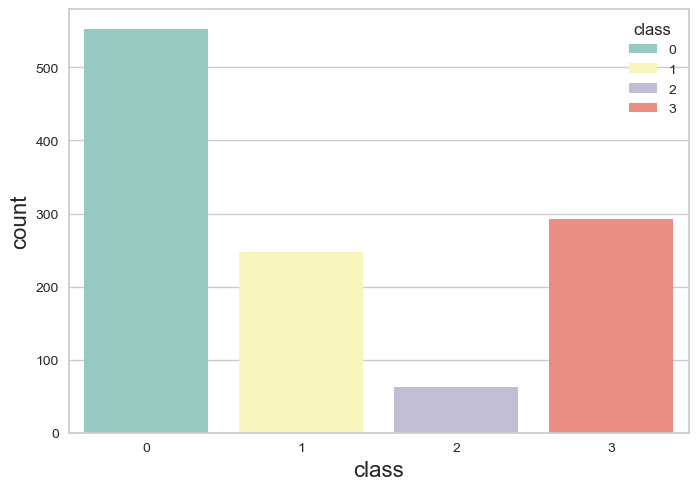

In [120]:
ax = sns.countplot(x="class", data=data_unproc, palette="Set3", hue="class", legend=True);
ax.set_xlabel("class", fontsize = 16)
ax.set_ylabel("count", fontsize = 16)
plt.show()

Klasse **0**: low valence and arousal <br>
Klasse **1**: high arousal, low valence  <br>
Klasse **2**: low arousal, high valence <br>
Klasse **3**: high arousal, valence <br>

Wie hier zu sehen, sind die Daten deutlich ungleich verteilt in unserer Annahme. Das gestaltet das Training von ML Modellen schwierig. Bei großen Datenmengen kann man mittels Downsampling eine Gleichverteilung erreichen. Das können wir hier nicht wirklich machen, da wir sonst die ohnehin schon geringe Zahl an Trainingsdaten von 1155 auf 252 verkürzen würden. 

In [121]:
data_unproc["class"].value_counts()

class
0    552
3    293
1    247
2     63
Name: count, dtype: int64

In [122]:
len(data_unproc)

1155

#### Korrelations-Heatmap
In der nachfolgenden Codezeile wird eine Heatmap erzeugt. Diese stellt grafisch die Korrelation zwischen zweier Variablen unseres Datensatzes dar. In diesem Fall bedeutet eine dunkelere Farbe in der Heatmap, dass die Variablen entlang der X und Y-Achse mehr miteinander korrelieren.

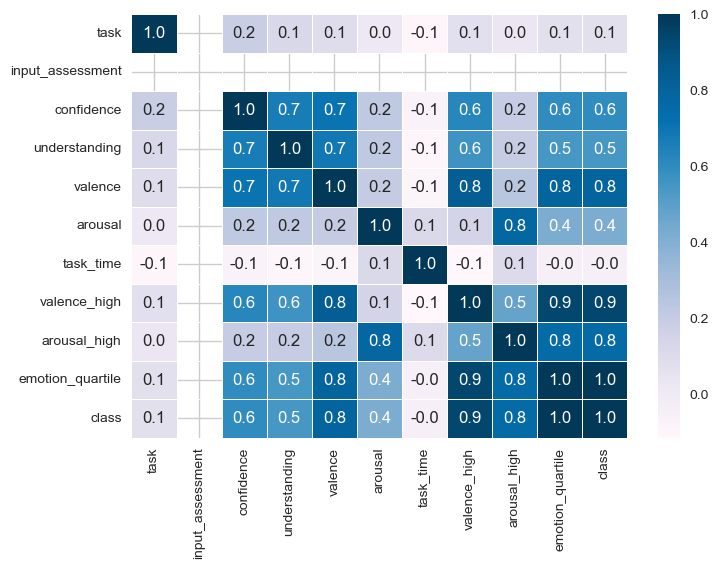

<Figure size 1400x1000 with 0 Axes>

In [123]:
ax = plt.axes()
plt.figure(figsize = (14,10))
sns.heatmap(data_unproc.select_dtypes(include=['number']).corr(), annot = True, fmt = ".1f", linewidths = .7, cmap="PuBu", ax = ax)
plt.show()

Korrelationen mit Klasse darf nicht verwendet werden, da wir eine Klassifikation vorliegen haben und die Klassenwerte 0, 1, 2, 3 nicht in einer Rangordnung stehen.

In [124]:
corr = data_unproc.select_dtypes(include=['number']).corr()

corr["class"].sort_values(ascending=False)

emotion_quartile    1.000000
class               1.000000
valence_high        0.935373
valence             0.791916
arousal_high        0.755966
confidence          0.595980
understanding       0.545838
arousal             0.419271
task                0.069892
task_time          -0.047734
input_assessment         NaN
Name: class, dtype: float64

In [125]:
data_unproc.select_dtypes(include=['number']).columns

Index(['task', 'input_assessment', 'confidence', 'understanding', 'valence',
       'arousal', 'task_time', 'valence_high', 'arousal_high',
       'emotion_quartile', 'class'],
      dtype='object')

/opt/homebrew/Caskroom/miniconda/base/envs/affective_user_research/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/homebrew/Caskroom/miniconda/base/envs/affective_user_research/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


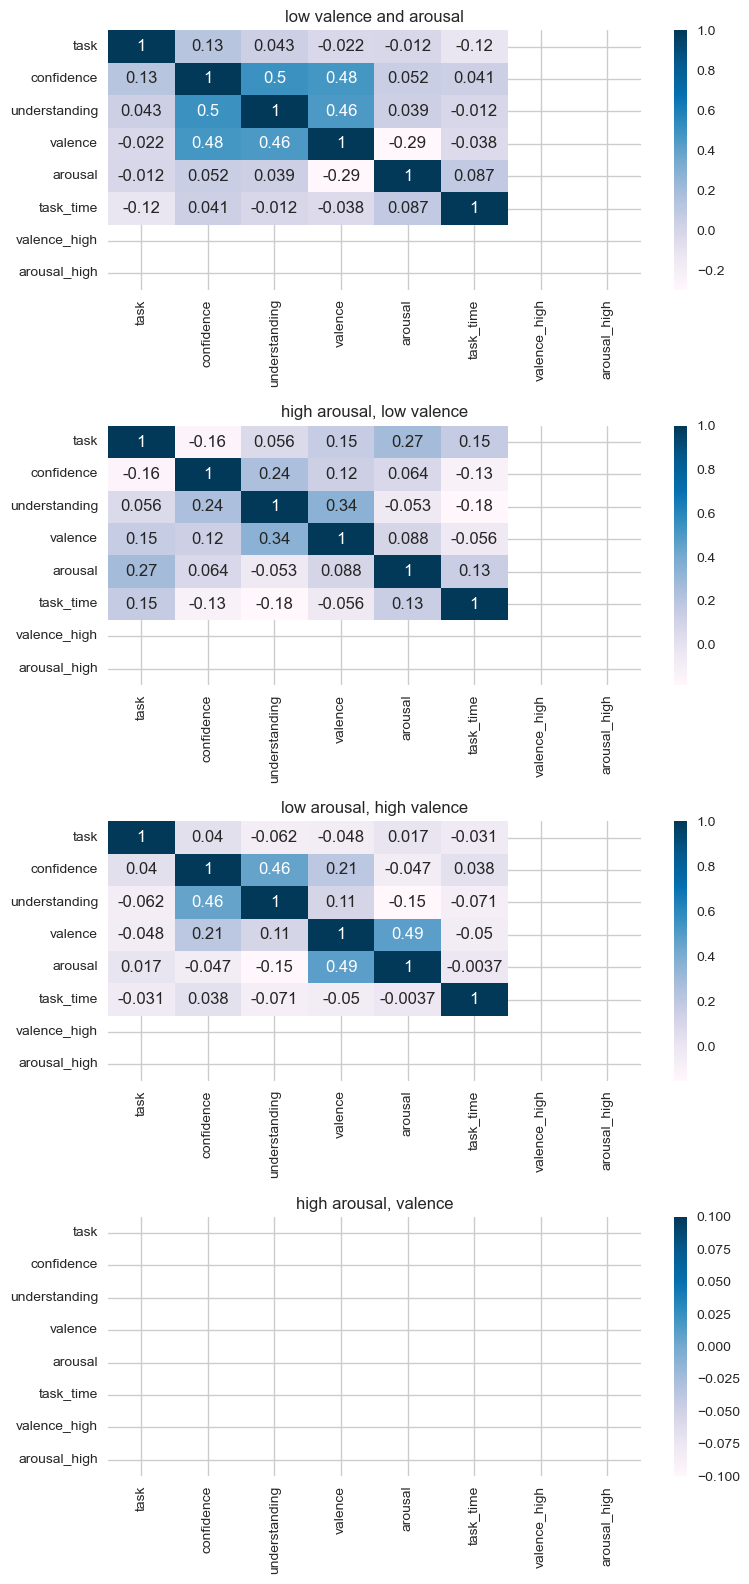

In [126]:
# Visualierung der Korrelation innerhalb der Klassen

fig, axes = plt.subplots(nrows=4, ncols=1,figsize=(8, 16))
fig.set_dpi(100)
ax = sns.heatmap(data_unproc[data_unproc['class']==1][['task', 'confidence', 'understanding', 'valence', 'arousal', 'task_time', 'valence_high', 'arousal_high']].corr(), ax = axes[0], cmap='PuBu', annot=True)
ax.set_title('low valence and arousal')
ax = sns.heatmap(data_unproc[data_unproc['class']==2][['task', 'confidence', 'understanding', 'valence', 'arousal', 'task_time', 'valence_high', 'arousal_high']].corr(), ax = axes[1], cmap='PuBu', annot=True)
ax.set_title('high arousal, low valence')
ax = sns.heatmap(data_unproc[data_unproc['class']==3][['task', 'confidence', 'understanding', 'valence', 'arousal', 'task_time', 'valence_high', 'arousal_high']].corr(), ax = axes[2], cmap='PuBu', annot=True)
ax = ax.set_title('low arousal, high valence')
ax = sns.heatmap(data_unproc[data_unproc['class']==4][['task', 'confidence', 'understanding', 'valence', 'arousal', 'task_time', 'valence_high', 'arousal_high']].corr(), ax = axes[3], cmap='PuBu', annot=True)
ax = ax.set_title('high arousal, valence')

plt.tight_layout()
plt.show()

# Nutzer-Clustering

- Können wir unsere Nutzer sinnvoll clustern? 
- Und wenn ja wie sehen diese Cluster aus? 

Um diese Fragen zu beantworten haben wir uns unterschiedliche Cluster Verfahren angeschaut. 

Zuerst haben wir das *DBSCAN Verfahren* genutzt, um ein allgemeines Gefühl für die Datenstruktur zu bekommen und mögliche Ausreißer zu identifizieren.

Da DBSCAN nicht gut funktioniert hat, haben wir den *k-means* benutzt, um eine einfache und schnelle Clusterung durchzuführen. 

Um eine tiefergehende Analyse und möglicherweise komplexere Clusterstrukturen zu identifizieren, die mit K-Means und DBSCAN nicht erfasst wurden, haben wir zuletzt noch *Spectral Clustering* betrachtet.


## DBSCAN

In [127]:
# Selektieren der relevanten Spalten
features = ['age', 'gender', 'education', 'assistant_usage', 'experience_analysis_tools', 
            'Trust 1', 'Trust 2', 'Trust 3', 'Satisfaction', 'Anthropomorphism']

# Trennen der numerischen und kategorialen Merkmale
numerical_features = ['age', 'experience_analysis_tools', 'Trust 1', 
                      'Trust 2', 'Trust 3', 'Satisfaction', 'Anthropomorphism']
categorical_features = ['gender', 'education', 'assistant_usage']

# Pipeline zur Vorverarbeitung erstellen
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)])

### DBSCAN-Modell erstellen und Pipeline aufsetzen

In [128]:
dbscan_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('cluster', DBSCAN(eps=0.2, min_samples=50))])

# Modell anwenden
user_information['cluster'] = dbscan_pipeline.fit_predict(user_information[features])

# Anzahl der Cluster anzeigen
print("Anzahl der Cluster:", len(set(user_information['cluster'])) - (1 if -1 in user_information['cluster'] else 0))
print(user_information['cluster'].value_counts())

Anzahl der Cluster: 1
cluster
-1    83
Name: count, dtype: int64


-> Mit dem DBSCAN finden wir nur ein Cluster. Als nächstes probieren wir den K-Means Algorithmus.

## K-Means Algorithmus

### Umwandlung der Daten

In [129]:

# Daten einlesen
df = user_information

# Umwandlung kategorischer Variablen in numerische Werte
label_encoder = LabelEncoder()

# Gender umwandeln
df['gender'] = label_encoder.fit_transform(df['gender'])

# Education umwandeln
education_mapping = {'middle_school': 0, 'abitur': 1, 'bachelor': 2, 'master': 3, 'phd': 4}
df['education'] = df['education'].map(education_mapping)

# Assistant usage umwandeln
usage_mapping = {'yearly': 0, 'monthly': 1, 'weekly': 2, 'daily': 3}
df['assistant_usage'] = df['assistant_usage'].map(usage_mapping)

# Auswahl der Features
features = ['age', 'gender', 'education', 'assistant_usage', 'experience_analysis_tools',
            'Trust 1', 'Trust 2', 'Trust 3', 'Satisfaction', 'Anthropomorphism']

X = df[features]

# Überprüfung auf fehlende Werte
if X.isnull().sum().sum() > 0:
    print("Es gibt fehlende Werte in den Daten. Diese werden mit dem Mittelwert aufgefüllt.")
    X = X.fillna(X.mean())

# Standardisierung der Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Es gibt fehlende Werte in den Daten. Diese werden mit dem Mittelwert aufgefüllt.


### Bestimmen der optimalen Anzahl von Clustern

Da wir für das k-means Clustering eine Anzahl k an Clustern angeben müssen, versuchen wir durch den Silhouette Score und die Elbow Methode auf eine optimale Anzahl k an Clustern zu kommen. 

#### Silhouette-Score

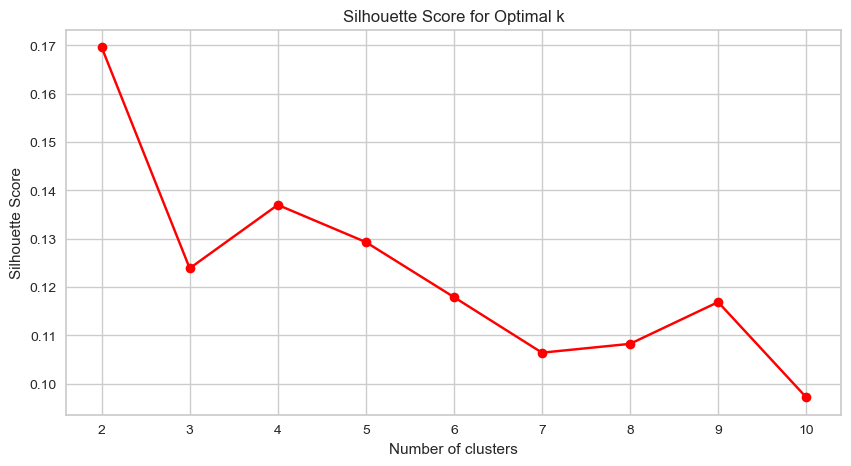

In [130]:

# Bestimmen der optimalen Anzahl von Clustern (Silhouette-Score)
wcss = []
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Silhouette-Score
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='red')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

Der Silhouette-Score misst, wie ähnlich ein Objekt zu seiner eigenen Clustergruppe im Vergleich zu anderen Clustergruppen ist. Ein höherer Silhouette-Score deutet auf eine bessere Trennung zwischen den Clustern hin. Wir wählen die Anzahl der Cluster bei denen der Silhouetten Score am höchsten ist: In diesem Fall k=2. 

#### Elbow-Method

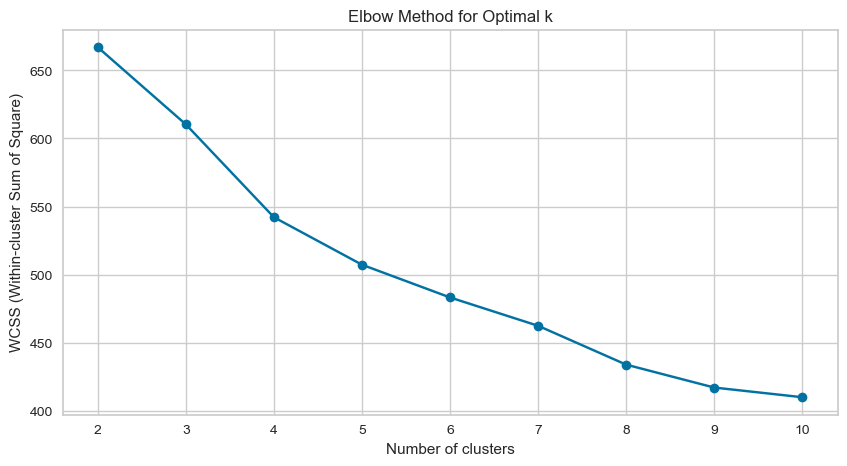

In [131]:
# Elbow-Methode
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within-cluster Sum of Square)')
plt.show()

Elbow-Methode sucht nach einem "Knickpunkt" in der Grafik der Summe der quadratischen Abstände innerhalb der Cluster (WCSS) gegen die Anzahl der Cluster. Der Punkt, an dem die Reduktion der WCSS signifikant abnimmt, wird als optimale Anzahl von Clustern angesehen.
Hier gibt es keinen klaren "Knickpunkt". Der WCSS-Wert sinkt stetig, aber es gibt keine deutliche Stelle, an der die Abnahme deutlich geringer wird.

-> Daher benutzen wir k=2 vom Silhouetten Score

### Analyse und Visualisierung
Verwendung von PCA zur Reduktion auf 2 Dimensionen zur Visualisierung

        age    gender  education  assistant_usage  experience_analysis_tools  \
0 -0.030532 -0.077176  -0.072926         0.184926                  -0.087332   
1  0.457159  0.390634   0.560230         0.113610                   0.493738   

    Trust 1   Trust 2   Trust 3  Satisfaction  Anthropomorphism  
0  0.504015  0.445576  0.508566      0.441393          0.199832  
1  0.086919 -0.032436  0.069336      0.169019         -0.160893  


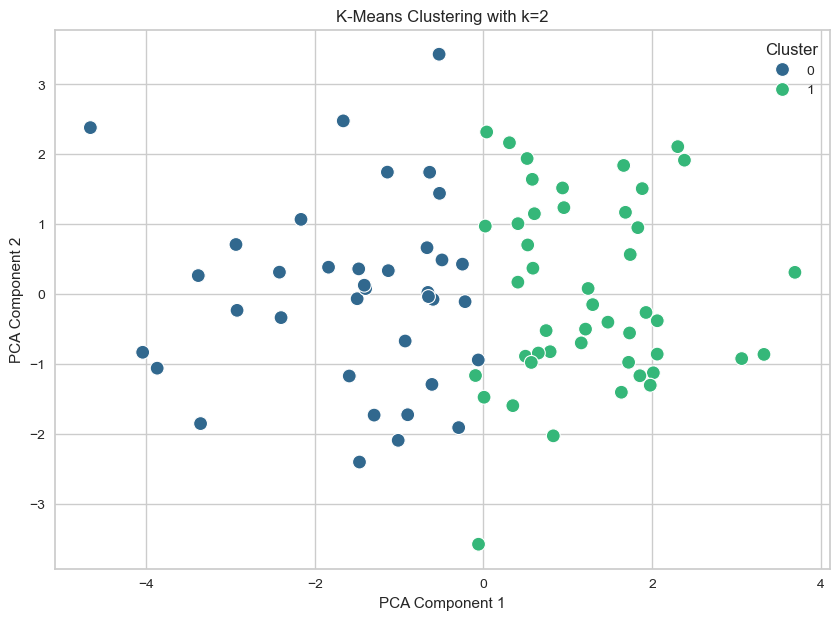

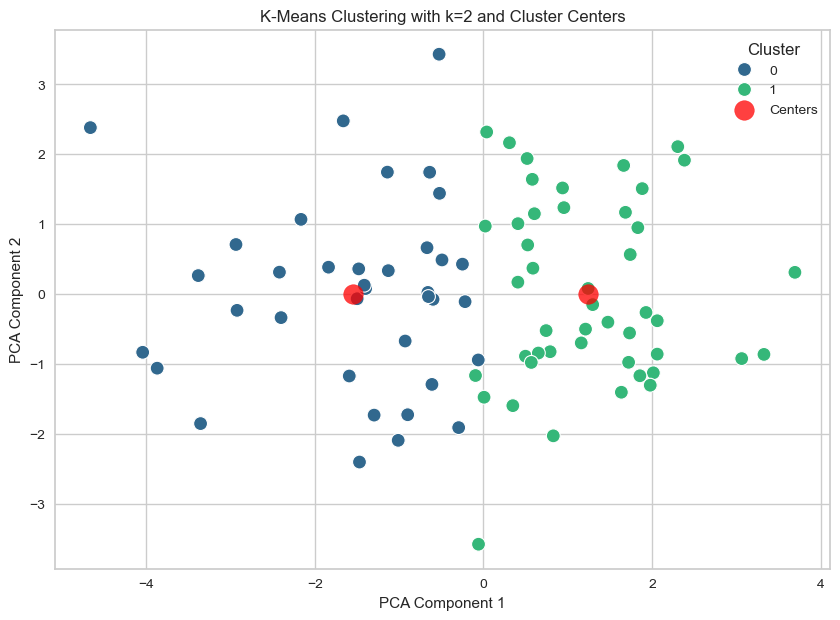

In [132]:
# K-Means Clustering mit der optimalen Anzahl von Clustern
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2  # Da range(2, 11) bei 2 beginnt
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Verwendung von PCA zur Reduktion auf 2 Dimensionen für Visualisierung
from sklearn.decomposition import PCA

features = ['age', 'gender', 'education', 'assistant_usage', 'experience_analysis_tools',
            'Trust 1', 'Trust 2', 'Trust 3', 'Satisfaction', 'Anthropomorphism']

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

# Überprüfen der PCA-Ladungen (Loadings)
X_pca = pca.fit_transform(X_scaled)


pca_loadings = pd.DataFrame(pca.components_, columns=features)  # Die Spaltennamen sind die Merkmale
print(pca_loadings)

df['pca_1'] = pca_components[:, 0]
df['pca_2'] = pca_components[:, 1]

# Visualisierung der Cluster
plt.figure(figsize=(10, 7))
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster', palette='viridis', data=df, s=100)
plt.title(f'K-Means Clustering with k={optimal_k}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Cluster-Zentren visualisieren
plt.figure(figsize=(10, 7))
centers = pca.transform(kmeans.cluster_centers_)
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster', palette='viridis', data=df, s=100)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, label='Centers')
plt.title(f'K-Means Clustering with k={optimal_k} and Cluster Centers')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


Es lassen sich mit dem k-means Clustering, zwei Cluster identifzieren. Um eine tiefergehende Analyse und möglicherweise komplexere Clusterstrukturen zu identifizieren, die mit K-Means und DBSCAN nicht erfasst wurden, wenden wir nun noch das Spectral Clustering an.

## Spectral Clustering

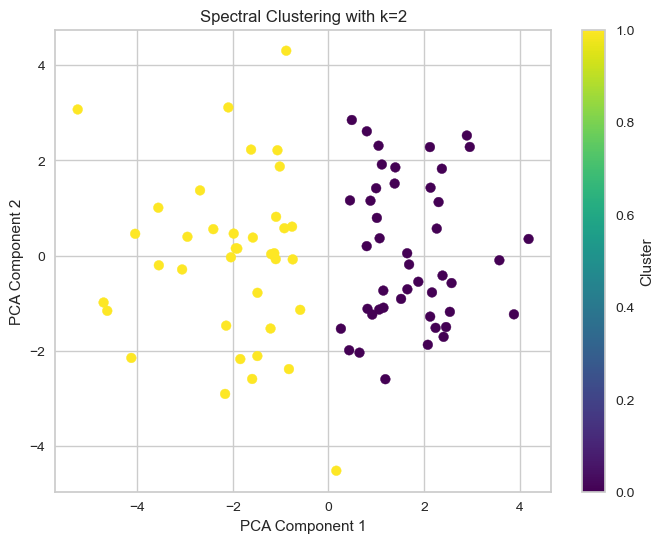

In [133]:
# Kategorische Daten kodieren
label_encoders = {}
for column in ['gender', 'education', 'assistant_usage']:
    le = LabelEncoder()
    user_information[column] = le.fit_transform(user_information[column])
    label_encoders[column] = le

# Features skalieren
X = user_information.drop('id', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Spectral Clustering anwenden
k = 2  # Anzahl der Cluster
spectral_clustering = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors')
user_information['cluster'] = spectral_clustering.fit_predict(X_scaled)



# PCA für die Visualisierung anwenden
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot der Cluster
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=user_information['cluster'], cmap='viridis')
plt.title(f'Spectral Clustering with k={k}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [134]:
# Überprüfen der PCA-Ladungen (Loadings)
pca_loadings = pd.DataFrame(pca.components_, columns=X.columns)

# Durchschnittswerte der Merkmale in den Clustern berechnen
cluster_means = user_information.groupby('cluster').mean()

# Ergebnis anzeigen
pca_loadings

,age,gender,education,assistant_usage,experience_analysis_tools,Trust 1,Trust 2,Trust 3,Satisfaction,Anthropomorphism,cluster,pca_1,pca_2
0,-0.019718,-0.055678,-0.007994,0.134524,-0.067710,0.402931,0.349311,0.41098,0.345787,0.169158,0.401323,0.459482,0.011107
1,0.370248,0.319819,0.422285,0.101502,0.397934,0.055404,-0.032794,0.04283,0.121689,-0.134972,-0.016756,-0.013090,0.611716


## Ergebnis
Unsere PCA Loadings geben an, welche User Merkmale zu welchem Grad in unser Modell einfließen. Ein hohes positives oder negatives Gewicht (Ladung) eines Merkmals in einer Komponente zeigt, dass das Merkmal stark zur entsprechenden Komponente beiträgt.

In unser PCA Loading 0 fließt Trust 1,2,3 und Satisfaction signifikant (hier definiert ±0.3) ein.

In unser PCA Loading 1 fließt Age, Gender, Education und Experience Analysis Tools signifikant (±0.3) ein. 

Assistant Usage und Anthropomorphism spielen hierbei keine signifikante Rolle.

## Weitere Fragen: Wie sähen die Personas aus, die in unserem Clustering vorhanden sind?

In [135]:
user_information.head()
cluster_means

,id,age,gender,education,assistant_usage,experience_analysis_tools,Trust 1,Trust 2,Trust 3,Satisfaction,Anthropomorphism,pca_1,pca_2
cluster,,,,,,,,,,,,,
0,178.044444,30.533333,1.422222,2.111111,1.822222,3.977778,5.422222,4.800000,4.733333,5.155556,1.955556,1.270787,0.082194
1,181.000000,31.368421,1.447368,1.947368,1.473684,4.342105,3.263158,2.815789,2.421053,3.500000,1.210526,-1.504879,-0.097335


In [136]:
# Angenommen, 'cluster_means' enthält die berechneten Durchschnittswerte
# Runden der Durchschnittswerte auf die nächste ganze Zahl
rounded_means = cluster_means.copy()
for column in label_encoders.keys():
    rounded_means[column] = rounded_means[column].round().astype(int)

# Umwandlung der gerundeten Werte in die ursprünglichen Kategorienamen
for column, le in label_encoders.items():
    rounded_means[column] = le.inverse_transform(rounded_means[column])

# Anzeigen der umgewandelten und gerundeten Durchschnittswerte
rounded_means

,id,age,gender,education,assistant_usage,experience_analysis_tools,Trust 1,Trust 2,Trust 3,Satisfaction,Anthropomorphism,pca_1,pca_2
cluster,,,,,,,,,,,,,
0,178.044444,30.533333,1,2.0,2,3.977778,5.422222,4.800000,4.733333,5.155556,1.955556,1.270787,0.082194
1,181.000000,31.368421,1,2.0,1,4.342105,3.263158,2.815789,2.421053,3.500000,1.210526,-1.504879,-0.097335


## Es lassen sich zwei Cluster darstellen mit zwei Personas: 
1. Persona benutzt wöchentlich einen Assistenten, hat eine große Erfahrung mit Analysis Tools, aber relativ wenig Vertrauen (Trust 1,2 und 3) und Zufriedenheit.
2. Persona benutzt monatlich einen Assistenten, hat weniger Erfahrung mit Analysis Tools aber mehr Vertrauen (Trust 1,2 und 3) und Zufriedenheit. 

## Zur weiteren Verarbeitung erstellen wir eine Tabelle, welche User zu welchem Cluster gehören. 

In [137]:
# Tabelle mit User IDs und Cluster-Zuordnungen erstellen
user_cluster = user_information[['id', 'cluster']]

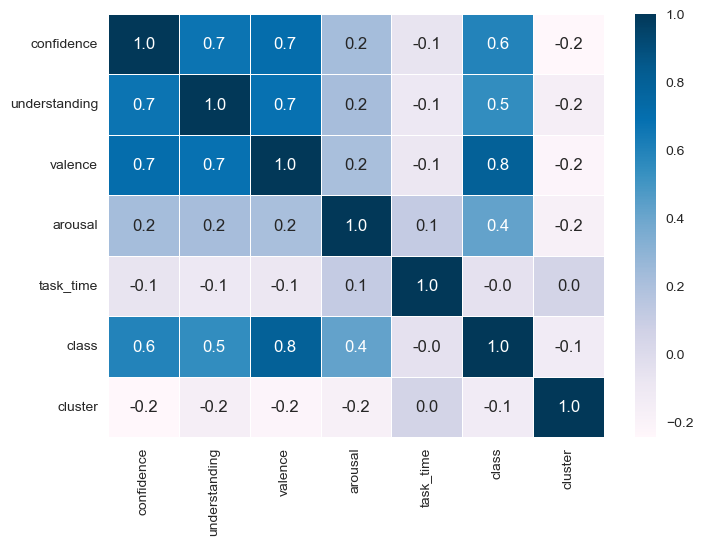

<Figure size 1400x1000 with 0 Axes>

In [138]:
cluster_corr = ee.merge(user_cluster, left_on='userId', right_on='id', how='left')
cluster_corr = cluster_corr.drop(columns=['id_x', 'id_y', 'userId', 'task', 'input_assessment', 'emotion_quartile', 'task_end', 'task_start', 'valence_high', 'arousal_high'])

ax = plt.axes()
plt.figure(figsize = (14,10))
sns.heatmap(cluster_corr.select_dtypes(include=['number']).corr(), annot = True, fmt = ".1f", linewidths = .7, cmap="PuBu", ax = ax)
plt.tight_layout()
plt.show()

Leider zeigt die Korrelationsanalyse, dass die User Cluster nicht erkennbar mit `confidence`, `understanding` oder `class` in Zusammenhang stehen. 

## Kann unser Clustering verbessert werden, wenn wir einzelne Features ausschließen?

In [139]:
ui = user_information

# Kategorische Daten kodieren
label_encoders = {}
for column in ['gender', 'education', 'assistant_usage']:
    le = LabelEncoder()
    ui[column] = le.fit_transform(ui[column])
    label_encoders[column] = le

# Liste der Features, die wir testen möchten
features = ['age', 'gender', 'education', 'assistant_usage', 'experience_analysis_tools', 
            'Trust 1', 'Trust 2', 'Trust 3', 'Satisfaction', 'Anthropomorphism']

# Ergebnisspeicher
results = []

# For-Schleife über alle Features, um sie nacheinander auszuschließen
for feature in features:
    # print(f"Testing without feature: {feature}")
    
    # Erstellen der Feature-Liste ohne das aktuelle Feature
    selected_features = [f for f in features if f != feature]
    
    # Features skalieren
    X = ui[selected_features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Spectral Clustering anwenden
    k = 2  # Anzahl der Cluster (dies kann angepasst werden)
    spectral_clustering = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors')
    clusters = spectral_clustering.fit_predict(X_scaled)
    
    # Berechnung des Silhouette-Scores als Maß für die Cluster-Qualität
    silhouette_avg = silhouette_score(X_scaled, clusters)
    # print(f"Silhouette Score: {silhouette_avg}")
    
    # Speichern der Ergebnisse
    results.append({
        'excluded_feature': feature,
        'silhouette_score': silhouette_avg
    })

# Umwandlung der Ergebnisse in einen DataFrame zur besseren Übersicht
results_df = pd.DataFrame(results)
results_df.sort_values(by='silhouette_score', ascending=False)

,excluded_feature,silhouette_score
2,education,0.188401
4,experience_analysis_tools,0.186641
3,assistant_usage,0.184359
1,gender,0.182688
0,age,0.177955
9,Anthropomorphism,0.176539
6,Trust 2,0.172240
8,Satisfaction,0.160083
5,Trust 1,0.145125
7,Trust 3,0.129190


=>  Nein, Silhouette Score verändert sich nicht merklich. Es gibt kein bestimmtes Merkmal, das Rauschen hinzufügt oder die Clusterbildung erschwert. 

# Feature Engineering

Im Folgenden fügen wir weitere Features zu den Daten hinzu, von denen wir glauben, dass sie die Vorhersagekraft eines Machine-Learning Modells verbessern können. 

## Hinzufügen der User Cluster als Feature

In [140]:
feature_eng_df = ee.merge(user_cluster, left_on='userId', right_on='id', how='left')
feature_eng_df = feature_eng_df.drop(columns=['id_x', 'id_y'])

## Hinzufügen User Information als Features

In [141]:
feature_eng_df = feature_eng_df.merge(user_information.drop(columns=['cluster', 'pca_1', 'pca_2']), left_on='userId', right_on='id', how='left')

## Erste & Letzte Prompts und Antworten der Interaktionen

In [142]:
md['agent_output'] = md['input'].apply(lambda x: json.loads(x).get('output'))
md['user_input'] = md['input'].apply(lambda x: json.loads(x).get('input'))

In [143]:
features_df = ee[ee['input_type'].isin(['final_output', 'llm_answer'])].copy()

# begin_or_end_of_interaction bestimmt, ob die am Anfang oder am Ende abgefragten valence/arousal Werte beachtet werden müssen
features_df['begin_or_end_of_interaction'] = features_df['input_type'].apply(lambda x: 'END' if x == 'final_output' else 'BEGIN')   

features_df = features_df[['userId', 'task', 'begin_or_end_of_interaction', 'valence', 'arousal', 'emotion_quartile']]

In [144]:
md_human_sorted = md[md['message_type'] == 'human'].sort_values(by=['userId', 'task', 'timestamp_unix'])
md_agent_sorted = md[md['message_type'] == 'agent_finish'].sort_values(by=['userId', 'task', 'timestamp_unix'])

first_prompt_per_interaction = md_human_sorted.groupby(['userId', 'task']).first().reset_index()
first_prompt_per_interaction['begin_or_end_of_interaction'] = 'BEGIN'

first_answer_per_interaction = md_agent_sorted.groupby(['userId', 'task']).first().reset_index()
first_answer_per_interaction['begin_or_end_of_interaction'] = 'BEGIN'


last_prompt_per_interaction = md_human_sorted.groupby(['userId', 'task']).last().reset_index()
last_prompt_per_interaction['begin_or_end_of_interaction'] = 'END'

last_answer_per_interaction = md_agent_sorted.groupby(['userId', 'task']).last().reset_index()
last_answer_per_interaction['begin_or_end_of_interaction'] = 'END'

second_last_answer_per_interaction = md_agent_sorted.groupby(['userId', 'task']).nth(-2).reset_index()
second_last_answer_per_interaction['begin_or_end_of_interaction'] = 'END'

## Länge der Prompts (in Worten)

In [145]:
# Füge Länge der ersten Prompt zum features_df hinzu
df = first_prompt_per_interaction.copy()
df['first_prompt_length'] = df['user_input'].apply(lambda x: len(x.split()))

features_df = pd.merge(features_df, df[['userId', 'task', 'begin_or_end_of_interaction', 'first_prompt_length']], on=['userId', 'task', 'begin_or_end_of_interaction'], how='left')

# Füge Länge der letzten Prompt zum features_df hinzu
df = last_prompt_per_interaction.copy()
df['last_prompt_length'] = df['user_input'].apply(lambda x: len(x.split()))

features_df = pd.merge(features_df, df[['userId', 'task', 'begin_or_end_of_interaction', 'last_prompt_length']], on=['userId', 'task', 'begin_or_end_of_interaction'], how='left')


# durchschnittliche Länge der Prompts in der Interaktion
df = md_human_sorted.copy()
df['avg_prompt_length'] = df['user_input'].apply(lambda x: len(x.split()))

df = df.groupby(['userId', 'task'])['avg_prompt_length'].mean().reset_index()

df['begin_or_end_of_interaction'] = 'END'

features_df = pd.merge(features_df, df[['userId', 'task', 'begin_or_end_of_interaction', 'avg_prompt_length']],
                       on=['userId', 'task', 'begin_or_end_of_interaction'], how='left')

## Länge der Assistent Antworten (in Worten)

In [146]:
# Füge Länge der ersten Antwort zum features_df hinzu
df = first_answer_per_interaction.copy()
df['first_answer_length'] = df['agent_output'].apply(lambda x: len(x.split()))

features_df = pd.merge(features_df, df[['userId', 'task', 'begin_or_end_of_interaction', 'first_answer_length']], on=['userId', 'task', 'begin_or_end_of_interaction'], how='left')

# Füge Länge der letzten Antwort zum features_df hinzu
df = last_answer_per_interaction.copy()
df['last_answer_length'] = df['agent_output'].apply(lambda x: len(x.split()))

features_df = pd.merge(features_df, df[['userId', 'task', 'begin_or_end_of_interaction', 'last_answer_length']], on=['userId', 'task', 'begin_or_end_of_interaction'], how='left')

# Durchschnittliche Länge der Antworten in der Interaktion
df = md_agent_sorted.copy()
df['avg_agent_answer_length'] = df['agent_output'].apply(lambda x: len(x.split()))

df = df.groupby(['userId', 'task'])['avg_agent_answer_length'].mean().reset_index()

df['begin_or_end_of_interaction'] = 'END'

features_df = pd.merge(features_df, df[['userId', 'task', 'begin_or_end_of_interaction', 'avg_agent_answer_length']],
                       on=['userId', 'task', 'begin_or_end_of_interaction'], how='left')

## Assistent Antwort-Zeit (in Sekunden)

In [147]:
# (erste Assistent Antwort Timestamp) - (Erste Prompt Timestamp)
df = pd.merge(first_answer_per_interaction[['userId', 'task', 'timestamp_unix', 'begin_or_end_of_interaction']], first_prompt_per_interaction[['userId', 'task', 'timestamp_unix', 'begin_or_end_of_interaction']], on=['userId', 'task', 'begin_or_end_of_interaction'], how='inner')
df['first_agent_answer_time'] = df['timestamp_unix_x'] - df['timestamp_unix_y']

features_df = pd.merge(features_df, df[['userId', 'task', 'begin_or_end_of_interaction', 'first_agent_answer_time']], on=['userId', 'task', 'begin_or_end_of_interaction'], how='left')

# (letzte Assistent Antwort Timestamp) - (letzte Prompt Timestamp)

df = pd.merge(last_answer_per_interaction[['userId', 'task', 'timestamp_unix', 'begin_or_end_of_interaction']], last_prompt_per_interaction[['userId', 'task', 'timestamp_unix', 'begin_or_end_of_interaction']], on=['userId', 'task', 'begin_or_end_of_interaction'], how='inner')
df['last_agent_answer_time'] = df['timestamp_unix_x'] - df['timestamp_unix_y']

features_df = pd.merge(features_df, df[['userId', 'task', 'begin_or_end_of_interaction', 'last_agent_answer_time']], on=['userId', 'task', 'begin_or_end_of_interaction'], how='left')

# Annahme: Antwort-Zeit ist unmittelbar, wenn negativ
features_df.loc[features_df['first_agent_answer_time'] < 0, 'first_agent_answer_time'] = 0
features_df.loc[features_df['last_agent_answer_time'] < 0, 'last_agent_answer_time'] = 0

## Prompt Anzahl pro Interaktion

In [148]:
df = md.copy()

df = df[df['message_type'] == 'human'].groupby(['userId', 'task']).size().reset_index(name='number_of_prompts')
df['begin_or_end_of_interaction'] = 'END'

features_df = pd.merge(features_df, df[['userId', 'task', 'begin_or_end_of_interaction', 'number_of_prompts']], on=['userId', 'task', 'begin_or_end_of_interaction'], how='left')

## Anzahl Click Events pro Interaktion

In [149]:
df = cd.copy()
print(f'Click Event Types: {df['event_type'].unique()}')

# Anzahl Clicks & Maximizations der Tabellen
df = df[(df['event_type'] == 'click_table') | (df['event_type'] == 'maximize_table')].groupby(['userId', 'task']).size().reset_index(name='number_of_clicks_on_tables')
df['begin_or_end_of_interaction'] = 'END'

features_df = pd.merge(features_df, df[['userId', 'task', 'begin_or_end_of_interaction', 'number_of_clicks_on_tables']], on=['userId', 'task', 'begin_or_end_of_interaction'], how='left')

# Anzahl Clicks auf Steps & Descriptions
df = cd.copy()
df = df[(df['event_type'] == 'click_step') | (df['event_type'] == 'click_description')].groupby(['userId', 'task']).size().reset_index(name='number_of_clicks_on_steps_and_descriptions')
df['begin_or_end_of_interaction'] = 'END'

features_df = pd.merge(features_df, df[['userId', 'task', 'begin_or_end_of_interaction', 'number_of_clicks_on_steps_and_descriptions']], on=['userId', 'task', 'begin_or_end_of_interaction'], how='left')

# Annahme: keine Werte in den Click-Events bedeuten, dass keine Klicks stattgefunden haben
features_df['number_of_clicks_on_tables'] = features_df['number_of_clicks_on_tables'].fillna(0)
features_df['number_of_clicks_on_steps_and_descriptions'] = features_df['number_of_clicks_on_steps_and_descriptions'].fillna(0)

Click Event Types: ['click_table' 'maximize_table' 'click_step' 'click_description']


In [150]:
feature_eng_df.columns

Index(['userId', 'task_type', 'task', 'input_type', 'input',
       'input_assessment', 'confidence', 'understanding', 'valence', 'arousal',
       'task_start', 'task_end', 'task_time', 'valence_high', 'arousal_high',
       'emotion_quartile', 'class', 'cluster', 'id', 'age', 'gender',
       'education', 'assistant_usage', 'experience_analysis_tools', 'Trust 1',
       'Trust 2', 'Trust 3', 'Satisfaction', 'Anthropomorphism'],
      dtype='object')

In [151]:
features_df.drop(columns=['valence', 'arousal', 'emotion_quartile'], inplace=True)
features_df.head()

,userId,task,begin_or_end_of_interaction,first_prompt_length,last_prompt_length,avg_prompt_length,first_answer_length,last_answer_length,avg_agent_answer_length,first_agent_answer_time,last_agent_answer_time,number_of_prompts,number_of_clicks_on_tables,number_of_clicks_on_steps_and_descriptions
0,124,1,END,NaN,27.0,27.0,NaN,46.0,46.0,NaN,16.0,1.0,0.0,0.0
1,124,2,END,NaN,16.0,16.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
2,124,3,END,NaN,7.0,11.5,NaN,6.0,10.0,NaN,8.0,2.0,0.0,0.0
3,124,3,BEGIN,16.0,NaN,NaN,14.0,NaN,NaN,15.0,NaN,NaN,0.0,0.0
4,124,4,END,NaN,3.0,7.5,NaN,20.0,20.0,NaN,9.0,2.0,0.0,0.0


In [152]:
df_full_features = feature_eng_df.merge(features_df[features_df['begin_or_end_of_interaction'] == 'END'], on=['userId', 'task'], how='inner')

## Kodierung von nicht-numerischen Spalten

In [153]:
# zeige nicht numerische Spalten des feature_eng_df
df_full_features.select_dtypes(include='object').columns

Index(['task_type', 'input_type', 'input', 'begin_or_end_of_interaction'], dtype='object')

In [154]:
label_encoder = LabelEncoder()

df_full_features['gender_numeric'] = label_encoder.fit_transform(df_full_features['gender'])
df_full_features['education_numeric'] = label_encoder.fit_transform(df_full_features['education'])
df_full_features['assistant_usage_numeric'] = label_encoder.fit_transform(df_full_features['assistant_usage'])

In [155]:
data_unproc = df_full_features

## Entfernen von Metadaten, die nicht für das Training verwendet werden sollen

In [156]:
data_unproc.drop(columns=['id', 'userId', 'task', 'task_type', 'begin_or_end_of_interaction'], inplace=True)

# Datenvorverabeitung Machine Learning

### Entfernung NaN Werte

Wir entfernen die Daten, welche nur einen Prompt zwischendrin darstellen und betrachten den letzten Teil der Konversation. Das erleichtert die Einheitlichkeit. 

In [157]:
print("Gesamte Datenpunkte: ", len(data_unproc))

data_unproc = data_unproc[data_unproc['input_type'] == 'final_output'].drop(columns=['input_type'])
data_unproc = data_unproc.dropna(axis=1, how='all').dropna(axis=0, how='any')
print("Final output Datenpunkte: ", len(data_unproc))

Gesamte Datenpunkte:  1144
Final output Datenpunkte:  364


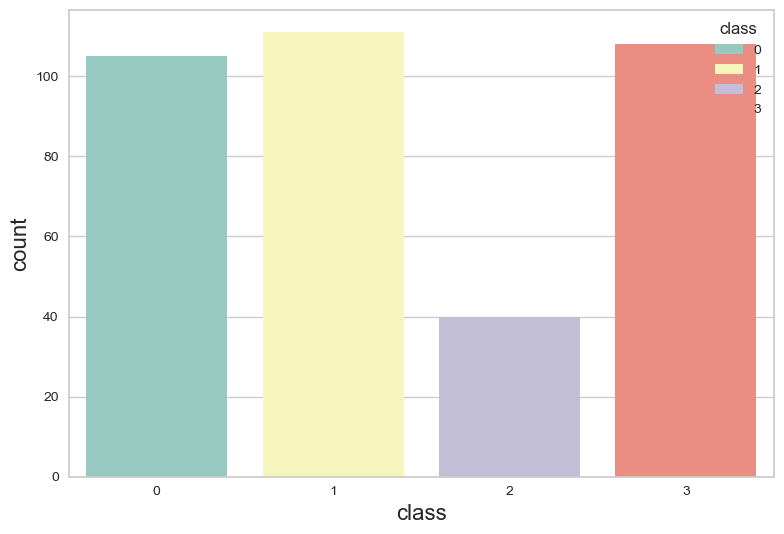

In [158]:
ax = sns.countplot(x="class", data=data_unproc, palette="Set3", hue="class")
ax.set_xlabel("class", fontsize = 16)
ax.set_ylabel("count", fontsize = 16)
plt.tight_layout()
plt.show()

Im Vergleich mit der ersten Analyse der Datenverteilung zu Beginn haben wir jetzt eine leicht bessere Verteilung der Klassen. Allerdings ist die Klasse 2 weiterhin stark unterrepräsentiert. 

## Train-Test-Split

Für das Trainieren und Evaluieren von Modellen werden 3 Datensätze empfohlen:

**Trainingsdaten**:

Diese werden für das Modelltraining genutzt.

**Validierungsdaten**:

Nach dem Training gilt es ein Modell auf dessen Güte zu testen. Hierfür sind grundsätzlich Testdaten vorgesehen, welche vom Modell vorher noch nicht gesehen und explizit von den Trainingsdaten ausgeschlossen wurden. Die Findung des besten Modells inklusive dessen Hyperparameter ist ein iterativer Prozess und ist dann beendet, sofern die gemessene Güte auf den Testdaten einen angemessenen Grad erreicht. Dies hat jedoch den Nachteil, dass das Modell extra so trainiert wurde, dass es auf diesen speziellen Testdatensatz optimal performt und auf tatsächlich neuen Daten in Produktion deutlich schlechter abschneiden könnte. Eine Lösung dieses Problems ist die sogenannte "Holdout validation": Ein Teil der Trainingsdaten wird dazu benutzt, um die optimalen Modelle zu finden. Trainiert werden diese Modelle auf dem nun reduzierten Trainigsdaten.

**Testdaten**:

Um eine Einschätzung zu bekommen, wie gut das Modell in Produktion performen wird, wird das Modell final mit den bis dahin noch nie gesehenen Testdaten evaluiert.

Für das Modelltraining der klassichen ML-Algorithmen (NaiveBayes, SVM, RandomForest,...) verzichten wir auf einen 3er-Split, da wir Hyperparameter-Optimierung mit Hilfe der Cross-Validation durchführen, wodurch kein Bias bezüglich des Testdatensatzes entsteht, da dieser erst bei der finalen Modellbewertung benutzt wird.

Wir nutzen insgesamt einen Split von `80-20`. Das führt unter diesen Umständen mit sehr limitierten Trainingsdaten zu deutlich besseren Ergebnissen als ein `70-30` Split und sollte dennoch gut generalisieren.

In [159]:
# independant features
X = data_unproc.drop(['class', 'emotion_quartile', 'arousal_high', 'valence_high', 'valence', 'arousal'], axis=1)
# dependant variable
y = data_unproc['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## DownSampling and Feature Scaling

### Skewed Data - Down- vs. Upsampling

Ein ungleichverteilter Datensatz liegt vor, wenn innerhalb des Datensatzes eine ungleiche Verteilung einer oder mehreren Klassen vorliegt. 
Die dabei mehrheitlich vorliegende Klasse wird dabei auch als *majority class* und die restlichen unter representierten Klassen als *minority class* bezeichnet. Ein solche Ungleichverteilung kann zur Folge haben, dass das resultieren Modell eine schlechtere Vorhersagegenauigkeit gegenüber der minority class aufweist und es somit zu einem sogenannten Overfitting kommt. Das Overfitting führt hierbei dazu, dass zwar eine hohe Vorhersagegenauigkeit gegenüber der majority class erzielt wird, das Modell jedoch gegenüber der minority class eine schlechte performance aufweist. Grund hierfür ist, dass das Modell nicht in der Lage ist, die zugrundeliegende Muster der minority classes zu erfassen [1]. 

Grundsätzlich unterscheidet man zwischen zwei Möglichkeiten, um mit stark unausgewogenen Datensätzen umzugehen, nämlich dem:  

**Down-Sampling**: Wird auf Klassen die zur majority classes angehören angewandt, wobei zufällig gewählte Datenpunkte der Klasse entfernt werden, um eine Gleichverteilung der Klassen zu erreichen. 

**Up-Sampling**: Wird dagegen auf Klassen angewandt die zur minority classes angehören, um die Datenmenge, auf die der majority class anzuheben.

[1] https://link.springer.com/content/pdf/10.1007/s42979-020-0074-0.pdf \
[2] https://doi.org/10.3389/fpubh.2020.00274

Da im vorliegenden Datensatz eine starke Ungleichverteilung festgestellt werden konnte, haben wir uns entschieden die Daten mittels Downsampling auszugleichen.  

#### Sampling

In [160]:
# Downsampling
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)
y_train.value_counts()

# Upsamling: Nur für Testzwecke verwenden
# ros = RandomOverSampler(random_state=42)
# X_train, y_train = ros.fit_resample(X_train, y_train)
# y_train.value_counts()

class
0    31
1    31
2    31
3    31
Name: count, dtype: int64

An diesere Stelle haben wir jetzt die Trainingsdaten erheblich reduziert. Aus vormals 1055 Datenpunkten werden nach der Entfernung der Zwischenevaluationen 405 Datenpunkte. Der Train-Test-Split kostet weitere 20% Trainingsdaten. Davon müssen auch wiederum einige aufgrund der Ungelichverteilung der Klassen vernachlässigt werden.

Allerdings sind wir der Überzeugung, dass diese Schritte nötig sind um das Modelltraining so zu gestalten, dass das Modell am Ende auch generalisieren kann und nicht nur einen hohen Fit auf Trainingsdaten erzielt. 

### Feature Scaling

Eine der wichtigsten Schritte im Data-Preprocessing ist das sog. "Feature scaling". Abgesehen von wenigen Ausnahmen, performen Machine Learning Algorithmen besser, wenn alle Attribute einheitlich skaliert sind. In unserem Fall haben die Daten sehr unterschiedliche Skalierungen. 

**Standardization**

Hierbei werden die Werte so reskaliert, dass diese anschließend eine Standardabweichung von 1 und einen Mittelwert von 0 haben. Im Gegensatz zu Min-Max Scaling werden die Werte hierbei nicht in einem festen Wertebereich (z.B. [0,1]) enden. Erreicht wird das mittels folgender Formel:
$$
x' = \frac{x - \overline{x}}{\sigma}
$$

Daneben ist Standardization weniger anfällig für Ausreißer, als bspw. ein min-max-Scaling.

In [161]:
X_train.head()

,input,confidence,understanding,task_start,task_end,task_time,cluster,age,gender,education,...,avg_prompt_length,last_answer_length,avg_agent_answer_length,last_agent_answer_time,number_of_prompts,number_of_clicks_on_tables,number_of_clicks_on_steps_and_descriptions,gender_numeric,education_numeric,assistant_usage_numeric
553,Oberwiehre,1.0,1.0,1.719868e+12,1.719868e+12,194.20,1,58,2,4,...,11.500000,55.0,34.500000,11.0,2.0,0.0,0.0,2,4,0
1068,\t Oberwiehre,5.0,5.0,1.720488e+12,1.720488e+12,178.24,1,26,2,1,...,9.200000,11.0,13.400000,7.0,5.0,4.0,0.0,2,1,2
969,Haslach-Weingarten; St. Georgen,4.0,5.0,1.720441e+12,1.720441e+12,257.54,0,35,1,3,...,8.333333,6.0,15.666667,8.0,3.0,4.0,0.0,1,3,2
705,93.238,5.0,4.0,1.719945e+12,1.719946e+12,110.72,0,26,1,3,...,8.000000,9.0,8.000000,8.0,2.0,0.0,0.0,1,3,0
726,Keine - der Assistent scheint sich aufgehängt ...,1.0,6.0,1.720000e+12,1.720000e+12,220.48,1,30,2,3,...,8.000000,24.0,24.000000,0.0,2.0,0.0,0.0,2,3,3


In [162]:
X_train = X_train.select_dtypes(include=['number'])
X_test = X_test.select_dtypes(include=['number'])

X_train.head()

,confidence,understanding,task_start,task_end,task_time,cluster,age,gender,education,assistant_usage,...,avg_prompt_length,last_answer_length,avg_agent_answer_length,last_agent_answer_time,number_of_prompts,number_of_clicks_on_tables,number_of_clicks_on_steps_and_descriptions,gender_numeric,education_numeric,assistant_usage_numeric
553,1.0,1.0,1.719868e+12,1.719868e+12,194.20,1,58,2,4,0,...,11.500000,55.0,34.500000,11.0,2.0,0.0,0.0,2,4,0
1068,5.0,5.0,1.720488e+12,1.720488e+12,178.24,1,26,2,1,2,...,9.200000,11.0,13.400000,7.0,5.0,4.0,0.0,2,1,2
969,4.0,5.0,1.720441e+12,1.720441e+12,257.54,0,35,1,3,2,...,8.333333,6.0,15.666667,8.0,3.0,4.0,0.0,1,3,2
705,5.0,4.0,1.719945e+12,1.719946e+12,110.72,0,26,1,3,0,...,8.000000,9.0,8.000000,8.0,2.0,0.0,0.0,1,3,0
726,1.0,6.0,1.720000e+12,1.720000e+12,220.48,1,30,2,3,3,...,8.000000,24.0,24.000000,0.0,2.0,0.0,0.0,2,3,3


In [163]:
# Pipeline für data preprocessing
pipeline = Pipeline([
    ("standardize", StandardScaler()),
])

pipeline.fit(X_train.select_dtypes(include=['number']))
X_train_transformed = pipeline.transform(X_train.select_dtypes(include=['number']))
X_test_transformed = pipeline.transform(X_test.select_dtypes(include=['number']))

# Evaluierungsmetriken

In [164]:
classes = ['low - low', 'high - low', 'low - high', 'high - high']

def confusion_matrix(y, y_pred):
    ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize="true", values_format=".0%", display_labels=classes)
    plt.show()

def roc(model, classes):
    visualizer = ROCAUC(model, classes=classes)
    visualizer.fit(X_train_transformed, y_train)        # Passe Trainingsdaten an Visualizer an
    visualizer.score(X_test_transformed, y_test)        # Bewerte das Model auf den Testdaten
    visualizer.show()                       # Finalisiere und zeige das Diagramm


def report(model, classes):
    print(classification_report(y_test, model.predict(X_test), target_names=classes))

def matthews(model):
    y_test_pred = model.predict(X_test)
    print(matthews_corrcoef(y_test, y_test_pred))

def prediction_error(model, classes=classes):
    visualizer = ClassPredictionError(model, classes=classes)
    visualizer.fit(X_train_transformed, y_train)        
    visualizer.score(X_test_transformed, y_test)   
    visualizer.show()   


## ROC-Kurve (Reciever Operation Characteristic)

Die ROC-Kurve stellt ein Hilfsmittel dar, um die Performance eines Modells anhand zweier Metriken zu bestimmen. Hierfür kommt es zur grafischen gegenüberstellung der Metriken *Recall* (tpr) und der *false-positive-rate* (fpr). Ähnlich wie bei der Precision-Recall-Kurve gilt es einen für das Szenario geigneten Kompromiss zwischen der tpr und fpr zu finden. Die Performance eines Zufallsklassifikatoren würde dabei die in Abbildung 1 zu sehende, in der diagonale liegende, gepunktete Linie entsprechen. Die Kurve eines perfekt klassifizierendes Modells dagegen, würde möglichst weit weg von dieser Linie entlang verlaufen (linke obere Ecke), da es gilt die tpr zu maximieren und die fpr zu minimieren. 

&emsp;&emsp;&emsp;&emsp; $$ recall = \frac{tp}{tp+fn} $$ &emsp;&emsp;&emsp;&emsp; $$ fpr = \frac{fp}{fp+tn} $$
<br/><br/>

Um nun die Performance eines Modells mit dem eines anderen vergleichen zu können, kann die Fläche unterhalb des Kurvenverlaufs berechnet werden (Area under the curve) und als Vergleichswert herangezogen werden. Des Weiteren konnte empirisch festgestellt werden, dass die AUC sich als ein geigneteres Maß als die Accuracy erweist [3].

[3] https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.102.5334&rep=rep1&type=pdf


Micro-Average: &emsp;&emsp;&emsp; $$ \sum_{i=1}^l\frac{tp_i}{tp_i+fp_i} $$ 
<br/><br/>
F1-Score: &emsp;&emsp;&emsp;$$ \frac{2*P*R}{P+R} $$ 
&emsp;&emsp;&emsp; &emsp;&emsp;&emsp; mit p = $$ \frac{tp}{tp +fp} $$&emsp;&emsp;&emsp;&emsp; r =  $$ \frac{tp}{tp +fn} $$

## Confusion Matrix

Mit Hilfe einer Konfusionmatrix lässt sich die performance eines binären Klassifikator bewerten. Die Grundlegende Idee besteht dabei darin zu erfassen, wie oft Instanzen einer Klasse richtig bzw. falsch klassifiziert werden. Die Zeilen in der Matrix repräsentiert die tatsächlichen Klasse des zugrundeliegenden Datensatzes, während die Spalten für die vorhergesagten Klassen des Modells stehen. Dabei steht die sogenannten *true-positive-rate* (tp) und *true-negative-rate* (tn) für die Anzahl an positiven/negativen Instanzen bei dem der Klassifikator eine richtige Vorhersage getroffen hat, während die *false-positve-rate* (fp) und die *false-negative-rate* (fn) die Anzahl der falsch klassifizierten positiven/negativen Instanzen. Auf Basis dieser Raten lassen sich anschließend verschiedene Metriken berechen, die aufschluss über die Performance des Modells geben: Accuracy, Precision, Recall, F1-Score

Die Konfusionsmatrix kann so erweitert werden, um diese auch für nicht binäre Klassifikatoren wie wir sie haben, zu verwenden. Des Weiteren ist zu beachten, dass sich die Berechnungsformel für die Metriken verändern. Anstelle der Precision verwendet man in diesem Fall den sogenannten macro- oder micro-average, wobei sich letzteres vor allem dann eignet, wenn eine ungleichverteilung der Klassen vorliegt.  



# Machine Learning

In [165]:
X_train.head()

,confidence,understanding,task_start,task_end,task_time,cluster,age,gender,education,assistant_usage,...,avg_prompt_length,last_answer_length,avg_agent_answer_length,last_agent_answer_time,number_of_prompts,number_of_clicks_on_tables,number_of_clicks_on_steps_and_descriptions,gender_numeric,education_numeric,assistant_usage_numeric
553,1.0,1.0,1.719868e+12,1.719868e+12,194.20,1,58,2,4,0,...,11.500000,55.0,34.500000,11.0,2.0,0.0,0.0,2,4,0
1068,5.0,5.0,1.720488e+12,1.720488e+12,178.24,1,26,2,1,2,...,9.200000,11.0,13.400000,7.0,5.0,4.0,0.0,2,1,2
969,4.0,5.0,1.720441e+12,1.720441e+12,257.54,0,35,1,3,2,...,8.333333,6.0,15.666667,8.0,3.0,4.0,0.0,1,3,2
705,5.0,4.0,1.719945e+12,1.719946e+12,110.72,0,26,1,3,0,...,8.000000,9.0,8.000000,8.0,2.0,0.0,0.0,1,3,0
726,1.0,6.0,1.720000e+12,1.720000e+12,220.48,1,30,2,3,3,...,8.000000,24.0,24.000000,0.0,2.0,0.0,0.0,2,3,3


## Vortesten der Modelle

In [166]:
df_results = pd.DataFrame(columns=['modelname', 'hyperparameter', 'optimized'])

def confusion_matrix(y, y_pred):
    ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize="true", values_format=".0%", display_labels=classes)
    plt.show()
   

def feature_importance(model):
    sorted_idx = model.feature_importances_.argsort()
    plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx])
    plt.xlabel(f'{model} Feature Importance')
    plt.show()

def evaluate_model(name, model, hyperparameter, y_pred_test, cv_score, cv_std, opt=False):
    
    global y_test

    # Confusion Matrix 
    confusion_matrix(y_test, y_pred_test)
    
    # ROC Kurve
    try:
        roc(model, classes)
    except:
        print("Model can't be displayed by Yellowbrick.")

    # Feature Importance Model
    try: 
        feature_importance(model)
    except AttributeError:
        print("The model can't display feature importance plot.")

    print(classification_report(y_test, y_pred_test, target_names=['low - low', 'high - low', 'low - high', 'high - high']))

    global df_results
    df_results = pd.concat([df_results, 
                            pd.DataFrame([{'modelname': name,
                                            'hyperparameter': hyperparameter,
                                            'accuracy_cv': cv_score,
                                            'std_cv': cv_std,
                                            'optimized': opt
                                        }])])

In [167]:
# Setzen eines einheitlichen Split für die Verwendung der Crossvalidation
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(5)

### Gaussian Naive Bayes Classifier

#### Erklärung GNB
Quelle: [StatsQuest](https://www.youtube.com/watch?v=H3EjCKtlVog) 

Der Gaussian Naive Bayes Classifier basiert auf dem Bayes Theorem: 

$$ Pr(Y=k|X=x) = \frac{\pi_k f_k(x)}{\sum_{l=1}^K\pi_lf_l(x)} $$

Zusammengefasst besagt das Bayes Theorem also, dass man die bedingte Wahrscheinlichkeit aus eine Annahme über die Verteilung der Klassen berechnen kann.

Mit dieser Erkenntnis lässt sich jetzt ein Klassifikator bauen, der die Klassenverteilung in den Trainingsdaten ermittelt und über diese die bedingte Wahrscheinlichkeit für die Klassenzuordnung in Abhängigkeit einer Inputvariable errechnet.

Gaussian Naive Bayes nimmt nun die Wahrscheinlichkeitsverteilungen je Attribut um den Mittelwert, die Gauss'sche Normalverteilung. An dieser werden für die Vorhersage die der Klasse entsprechenende Werte abgelesen und der Logarithmus dieser Wahrscheinlichkeiten berechnet und anschließend addiert. Die Klasse mit dem höheren Wert wird vorhergesagt.

Der Logarithmus dient dabei der Vermeidung eines Underflow, bei dem die Zahlen für die Wahrscheinlichkeiten so klein werden, dass ein Computer sie nicht mehr korrekt, oder nur mit hohem Speicheraufwand, speichern kann. Durch den Logarithmus werden Werte nahe null zu größeren negativen Werten.


In [168]:
gnb_clf = GaussianNB()
gnb_clf.fit(X_train_transformed, y_train)

gnb_y_pred_test = gnb_clf.predict(X_test_transformed) # wird für Confusion Matrix verwendet

In [169]:
gnb_clf_pipe = Pipeline([
    ("standardize", StandardScaler()),
    ('gnb', GaussianNB())
])

gnb_cv = cross_val_score(gnb_clf_pipe, X_train, y_train, cv=cv)

In [170]:
print(gnb_cv)

[0.4   0.44  0.28  0.56  0.375]


In [171]:
pd.Series(gnb_cv).describe()

count    5.000000
mean     0.411000
std      0.102005
min      0.280000
25%      0.375000
50%      0.400000
75%      0.440000
max      0.560000
dtype: float64

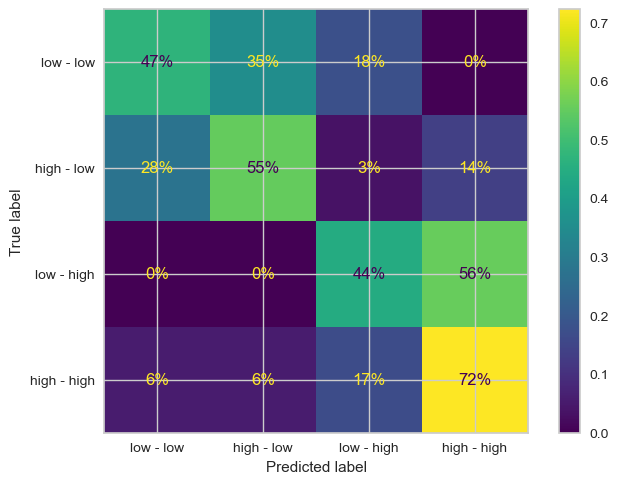

Model can't be displayed by Yellowbrick.
The model can't display feature importance plot.
              precision    recall  f1-score   support

   low - low       0.47      0.47      0.47        17
  high - low       0.70      0.55      0.62        29
  low - high       0.36      0.44      0.40         9
 high - high       0.59      0.72      0.65        18

    accuracy                           0.56        73
   macro avg       0.53      0.55      0.53        73
weighted avg       0.58      0.56      0.56        73



In [172]:
evaluate_model('GaussianNB', gnb_y_pred_test, str(gnb_clf.get_params()), gnb_y_pred_test, mean(gnb_cv), std(gnb_cv))

### Support Vector Machine

Quelle: [tds](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47) 

Support Vektor Maschinen sind Modelle aus dem Bereich supervised learning. Sie könne für Klassifikation und numerische Vorhersagen verwendet werden. Für die Klassifizierung versucht der Algorithmus eine mehrdimensionale Hyperplane zu finden, welche die Daten in die Kategorien aufteilt. Die Optimierung geschieht über die Maximierung des Abstands von Vektoren.

Für diese Daten könnte das Modell gut geeignet sein, da man für einige Parameter eine Entscheidungsgrenze im Verteilungplot schon erahnen kann. 

In [173]:
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train_transformed, y_train)

svm_y_pred_test = svm_clf.predict(X_test_transformed)

In [174]:
svm_clf_pipe = Pipeline([
    ("standardize", StandardScaler()),
    ('svc', SVC(random_state=42))
])
svm_cv = cross_val_score(svm_clf_pipe, X_train, y_train, cv=cv)

In [175]:
pd.Series(svm_cv).describe()

count    5.000000
mean     0.427333
std      0.071663
min      0.320000
25%      0.416667
50%      0.440000
75%      0.440000
max      0.520000
dtype: float64

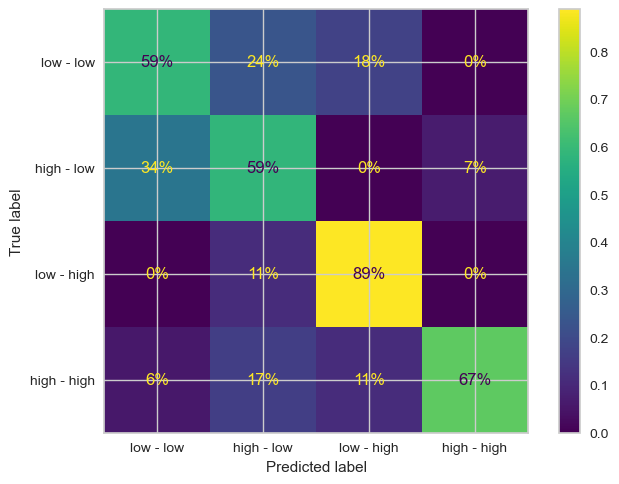

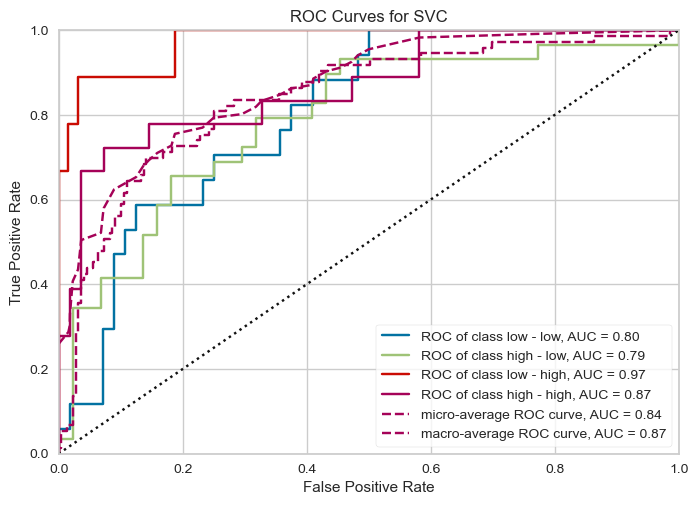

The model can't display feature importance plot.
              precision    recall  f1-score   support

   low - low       0.48      0.59      0.53        17
  high - low       0.68      0.59      0.63        29
  low - high       0.62      0.89      0.73         9
 high - high       0.86      0.67      0.75        18

    accuracy                           0.64        73
   macro avg       0.66      0.68      0.66        73
weighted avg       0.67      0.64      0.65        73



In [176]:
evaluate_model('SVC', svm_clf, str(svm_clf.get_params()), svm_y_pred_test, mean(svm_cv), std(svm_cv))

### Decision Tree

Ein Decision Tree (z.d. Entscheidungsbaum) ist eine supervised learning Methode zur Regression oder Klassifikation von Daten, welche nach dem Teile-und-herrsche-Verfahren arbeitet. Dabei wird versucht aus einer Datenmenge heraus eine hierarchische Struktur (im Form eines Baumes) zu bilden, um Daten auf Grundlage von Regeln zu klassifizieren. 

In [177]:
dtc_clf = DecisionTreeClassifier(random_state=42)
dtc_clf.fit(X_train_transformed, y_train)

dtc_y_pred_test = dtc_clf.predict(X_test_transformed)

In [178]:
dtc_clf_pipe = Pipeline([
    ("standardize", StandardScaler()),
    ('dtc', DecisionTreeClassifier(random_state=42))
])
dtc_cv = cross_val_score(dtc_clf_pipe, X_train, y_train, cv=cv)

In [179]:
pd.Series(dtc_cv).describe()

count    5.000000
mean     0.451333
std      0.129520
min      0.320000
25%      0.360000
50%      0.416667
75%      0.520000
max      0.640000
dtype: float64

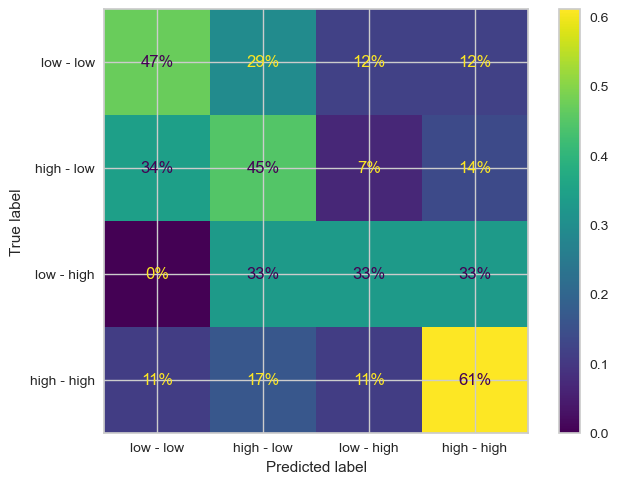

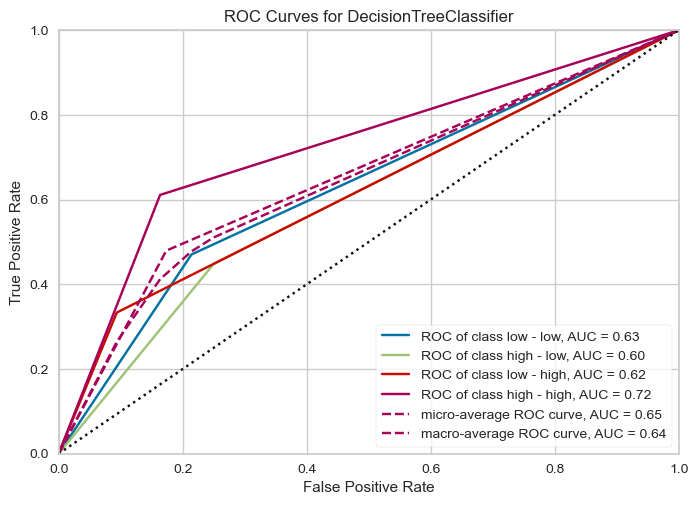

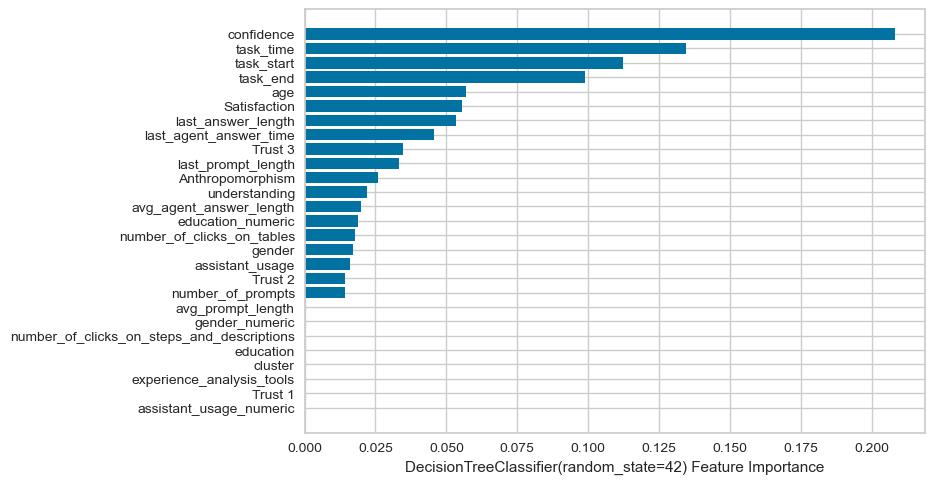

              precision    recall  f1-score   support

   low - low       0.40      0.47      0.43        17
  high - low       0.54      0.45      0.49        29
  low - high       0.33      0.33      0.33         9
 high - high       0.55      0.61      0.58        18

    accuracy                           0.48        73
   macro avg       0.46      0.47      0.46        73
weighted avg       0.49      0.48      0.48        73



In [180]:
evaluate_model('DecisionTreeClassifier', dtc_clf, str(dtc_clf.get_params()), 
                dtc_y_pred_test, mean(dtc_cv), std(dtc_cv))

### Random Forest

Ein Random Forest Klassifikator ist ein Ensemble von Entscheidungsbäumen, die mit der Bagging-Methode trainiert werden, wobei die Auswahl an Attributen zufällig erfolgt (randomization). Bei der Bagging-Methode (Bootstrap Aggregation) werden mehrere zufällig gewählte Samples (ziehen mit zurücklegen) aus dem original Datensatz erstellt, um anschließend mehrere, in diesem Falle Entscheidungsbäume, unabhängig voneinander zu trainieren. Das bedeutet, dass die entstehenden Entscheidungsbäume nach unterschiedlichen Attribute splitten.



In [181]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_transformed, y_train)


rf_y_pred_test = rf_clf.predict(X_test_transformed)

In [182]:
rf_clf_pipe = Pipeline([
    ("standardize", StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])
rf_cv = cross_val_score(rf_clf_pipe, X_train, y_train, cv=cv, scoring="accuracy")

In [183]:
pd.Series(rf_cv).describe()

count    5.000000
mean     0.556000
std      0.104307
min      0.480000
25%      0.480000
50%      0.500000
75%      0.600000
max      0.720000
dtype: float64

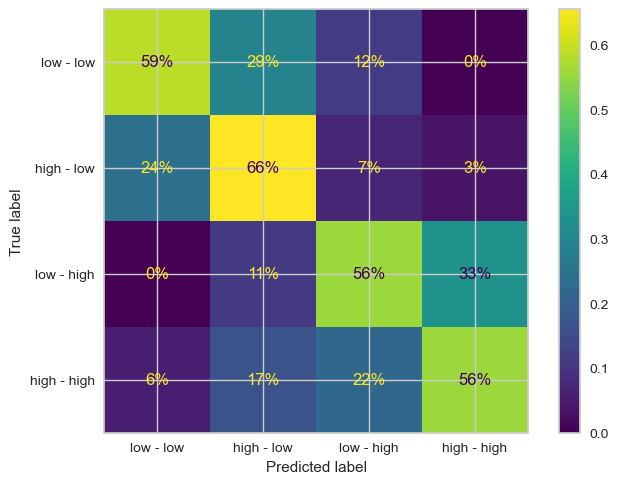

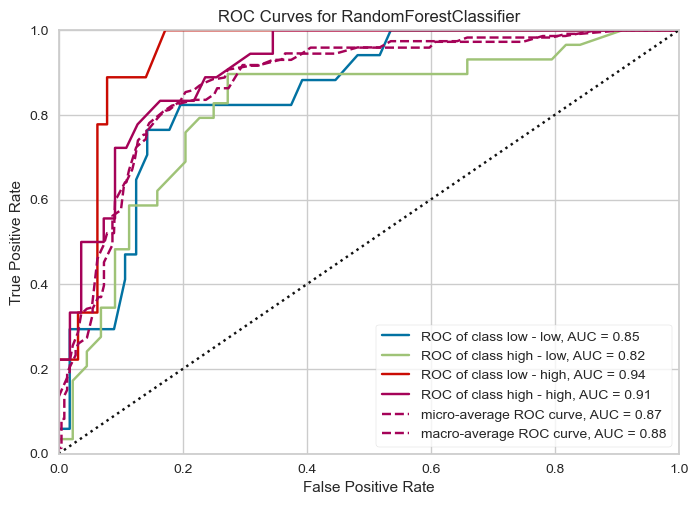

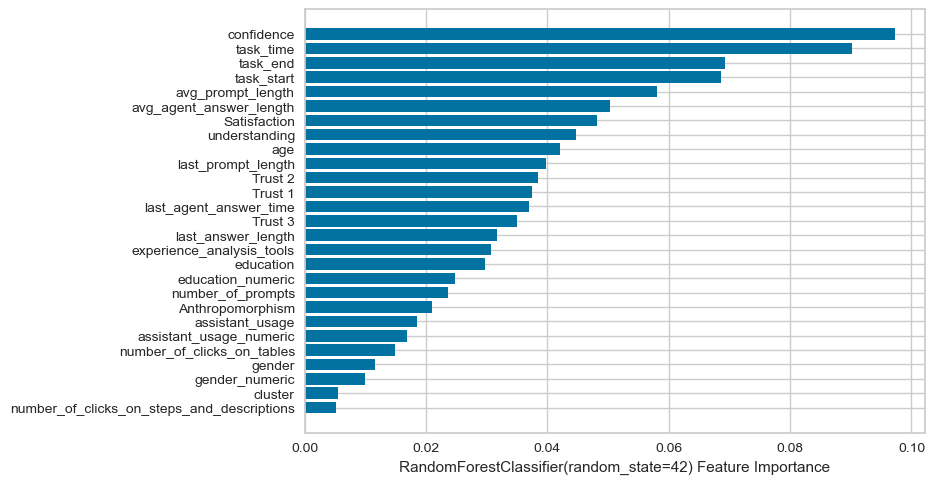

              precision    recall  f1-score   support

   low - low       0.56      0.59      0.57        17
  high - low       0.68      0.66      0.67        29
  low - high       0.38      0.56      0.45         9
 high - high       0.71      0.56      0.62        18

    accuracy                           0.60        73
   macro avg       0.58      0.59      0.58        73
weighted avg       0.62      0.60      0.61        73



In [184]:
evaluate_model('RandomForestClassifier', rf_clf, str(rf_clf.get_params()), 
                rf_y_pred_test, mean(rf_cv), std(rf_cv))

### KNN (k-nearest-neighbors)

In [185]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_transformed, y_train)

knn_y_pred_test = knn_clf.predict(X_test_transformed)

In [186]:
knn_clf_pipe = Pipeline([
    ("standardize", StandardScaler()),
    ('knn', KNeighborsClassifier())
    ])
knn_cv = cross_val_score(knn_clf_pipe, X_train, y_train, cv=cv)

In [187]:
pd.Series(knn_cv).describe()

count    5.000000
mean     0.420000
std      0.052915
min      0.360000
25%      0.400000
50%      0.400000
75%      0.440000
max      0.500000
dtype: float64

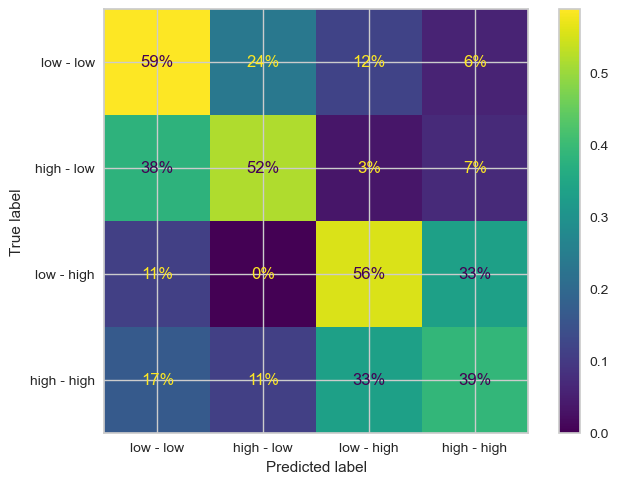

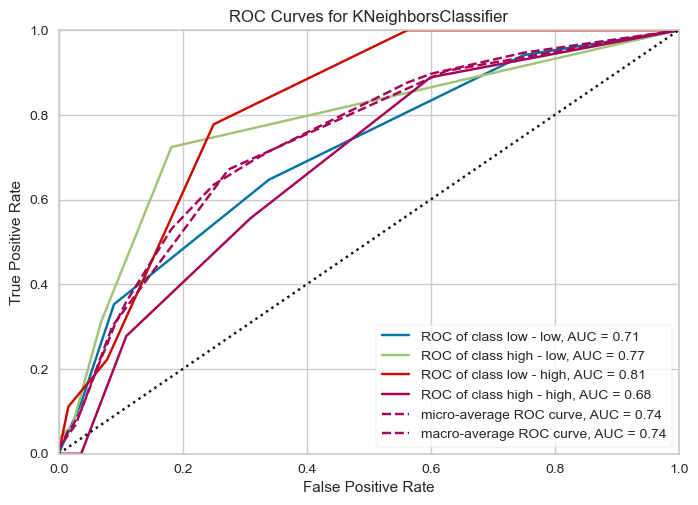

The model can't display feature importance plot.
              precision    recall  f1-score   support

   low - low       0.40      0.59      0.48        17
  high - low       0.71      0.52      0.60        29
  low - high       0.36      0.56      0.43         9
 high - high       0.54      0.39      0.45        18

    accuracy                           0.51        73
   macro avg       0.50      0.51      0.49        73
weighted avg       0.55      0.51      0.51        73



In [188]:
evaluate_model('KNeighborsClassifier', knn_clf, str(knn_clf.get_params()), 
                knn_y_pred_test, mean(knn_cv), std(knn_cv))

### Logistic Regression Classifier

Quellen: [hackernoon](https://hackernoon.com/introduction-to-machine-learning-algorithms-logistic-regression-cbdd82d81a36)
[James, G., Witten, D., Hastie, T., & Tibshirani, R. (2017). An introduction to statistical learning : With applications in R (Corrected at 8th printing ed., Springer texts in statistics). New York Heidelberg Dordrecht London.](https://primo.bib.uni-mannheim.de/permalink/f/17313ps/MAN_ALMA21197109840002561)

Die Logistische Regression ist eine der am häufigsten Algorithmen für Klassifizierung. Die Klassifizierung funktioniert über das Anpassen einer Aktivierungsfunktion, der Sigmoid-Funktion.

*Logistic Regression is one of the simplest and most used regression algorithms. In contrast to linear Regression it doesn't have rely on a linear function. This can be used to make better classification predictions. It is based on an activation function, most of the time this activation function is a Sigmoid function. The Sigmoid function is very good in separating numeric values into two classes. Low negative values are mapped to -1 and high positive values are mapped to 1. The key however is the transition between the two classes, it is very narrow. Because it is so narrow the values are likely beeing classified as either -1 or 1. 

To optimize the output, we again need a cost function and the gradients, derived from the cost function. Here is the cost function: 

$$\frac{-1}{m}\sum^m_{i=1}y^{(i)}\log{h_\theta(x^{(i)})}+(1-y^{(i)}\log{(1-h_\theta(x^{(i)}))}$$

The gradient is the derivation of the cost function.*

Wir erwarten keine besonders gute Performance dieses Algorithmus, da für seine optimale Performance die Entscheidungsgrenzen sehr klar sein müssten zwischen den Variablen. 

In [189]:
lr_clf = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_clf.fit(X_train_transformed, y_train)

lr_y_pred_test = lr_clf.predict(X_test_transformed)

In [190]:
lr_clf_pipe = Pipeline([
    ("standardize", StandardScaler()),
    ('lr', LogisticRegression(solver='lbfgs', max_iter=1000))
])
lr_cv = cross_val_score(lr_clf_pipe, X_train, y_train, cv=cv)

In [191]:
pd.Series(lr_cv).describe()

count    5.000000
mean     0.394667
std      0.105240
min      0.320000
25%      0.320000
50%      0.333333
75%      0.440000
max      0.560000
dtype: float64

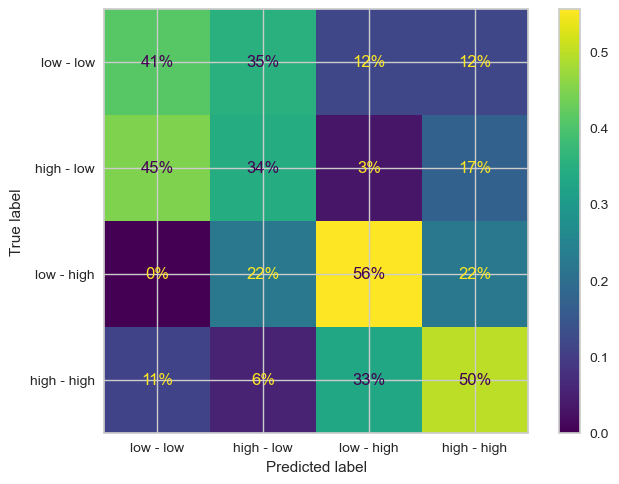

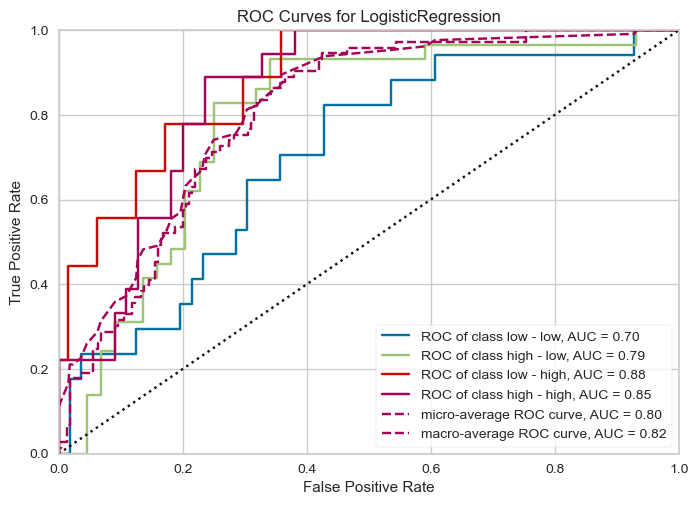

The model can't display feature importance plot.
              precision    recall  f1-score   support

   low - low       0.32      0.41      0.36        17
  high - low       0.53      0.34      0.42        29
  low - high       0.36      0.56      0.43         9
 high - high       0.50      0.50      0.50        18

    accuracy                           0.42        73
   macro avg       0.43      0.45      0.43        73
weighted avg       0.45      0.42      0.43        73



In [192]:
evaluate_model('LogisticRegression', lr_clf, str(lr_clf.get_params()), 
                lr_y_pred_test, mean(lr_cv), std(lr_cv))

### Ergebnisse

In [193]:
df_results.sort_values('accuracy_cv', ascending=False)

,modelname,hyperparameter,optimized,accuracy_cv,std_cv
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",False,0.556000,0.093295
0,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",False,0.451333,0.115847
0,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",False,0.427333,0.064097
0,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",False,0.420000,0.047329
0,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",False,0.411000,0.091236
0,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",False,0.394667,0.094130


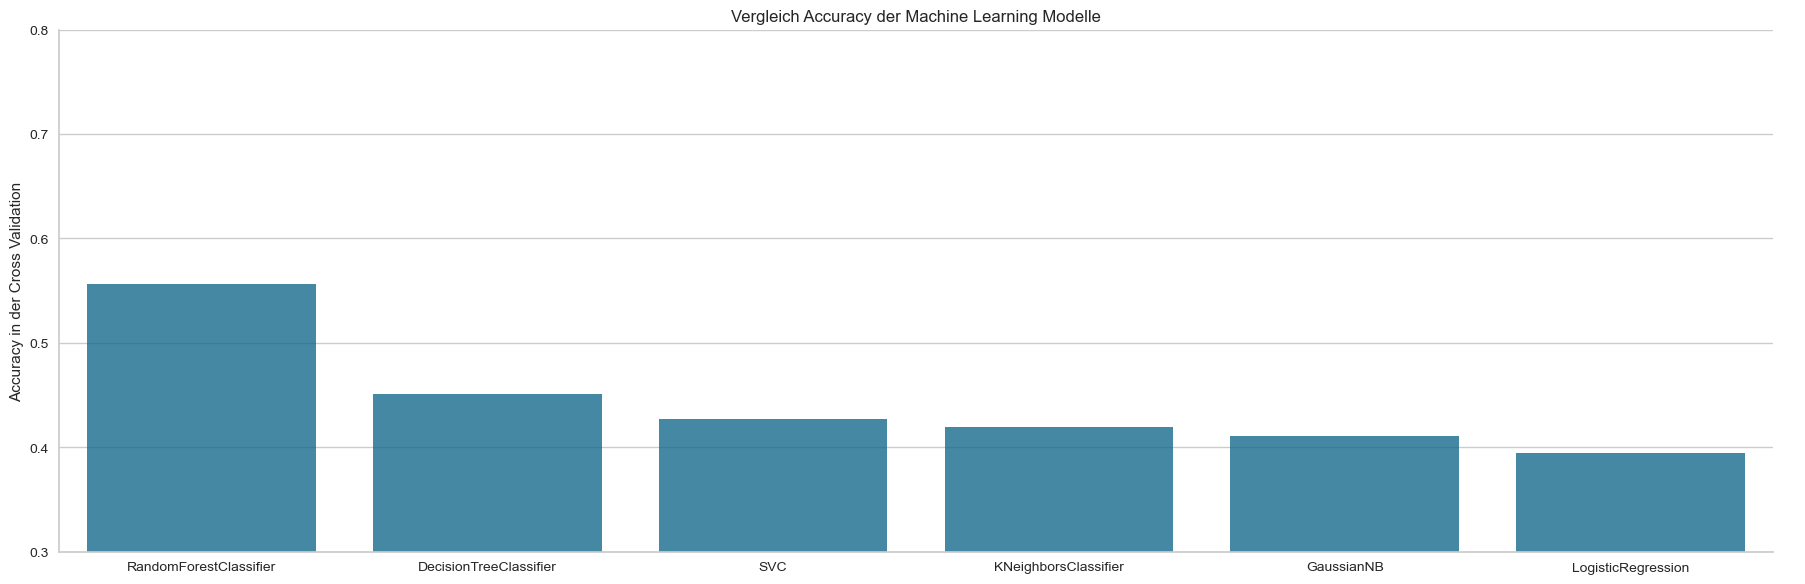

In [194]:
bp = sns.catplot(
    data=df_results.sort_values('accuracy_cv', ascending=False), 
    kind="bar",
    x="modelname", y="accuracy_cv",
    alpha=.8, height=6, aspect=3)
bp.set_axis_labels("", "Accuracy in der Cross Validation")
plt.title("Vergleich Accuracy der Machine Learning Modelle")
plt.ylim([0.3, 0.8])
plt.show()

## Optimiertes Modell Training (Hyperparameter-Tuning)

In [195]:
gnb_param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

knn_param_grid = {'n_neighbors': np.arange(4, 8),
                   'weights': ['uniform', 'distance'],
                   'metric': ['euclidean', 'manhattan']}
                   
dtc_param_grid = {'criterion':['gini', 'entropy'],'max_depth':[7,8,9,10,15,20,30]}

svm_param_grid = {'C': np.arange(7, 12), # tested with [3, 12]
                    'gamma': [0.001, 0.01, 0.1, 1, 10, 100]} # tested with [0.001, 0.01, 0.1, 1, 10, 100]

rf_param_grid = {
    'max_depth': np.arange(2, 9), # tested with [4, 15]
    'min_samples_leaf': np.arange(2, 7), # tested with [2, 12]
    'min_samples_split': np.arange(2, 4), # tested with [2, 12]
    } 

Die vorige Analyse der verschiedenen Modell für die Klassifizierung ließ uns eine erste Einschätzung der Güte der Modell treffen. Die vielversprechenden Kandidaten (Gaussian-Naive-Bayes Classifier, Support Vector Machine, Decision Tree, Random Forest, K-Nearest-Neighbours) werden wir nun versuchen zu optimieren. Dafür wenden wir ein sogenanntes Hyperparametertuning mittels Grid-Search an. Das bedeutet, dass wir die Modelle vielfach mit verschiedenen Parametern trainieren, um die Performance weiter zu verbessern. Die Parameter unterscheiden sich dabei von Modell zu Modell, bspw. beim random forest optimieren wir die minimale beispiel blätter, maximale Tiefe und das minimale sample split.

Für die Optimierung verwenden wir die sklearn [GridSearchCV-Funktion](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Die Evaluierung der Modelle erfolgt über Cross-Validation

#### Cross Validation

Cross-Validation ist ein Verfahren, um Modelle zu evaluieren, ohne sie auf den Testdaten laufen zu lassen. Für die Cross-Validation wird der Trainingsdatensatz in n gleich große Teile gespalten. Dann wird einer dieser Teile als *validation set* zurück gehalten, während auf den verbliebenen n-1 Datensätzen gemeinsam das Modell trainiert wird. So können entweder n verschieden Modell trainiert werden oder, wie in unserem Fall, dasselbe Modell n mal, um einen Fehlerwert für die Vorhersagefähigkeit der Modell zu erhalten. 

In [196]:
gnb_grid_search = GridSearchCV(estimator=gnb_clf,
        param_grid=gnb_param_grid,
        scoring='accuracy',
        cv=cv)
        
svm_grid_search = GridSearchCV(estimator=svm_clf,
        param_grid=svm_param_grid,
        scoring='accuracy',
        cv=cv)

rf_grid_search = GridSearchCV(estimator=rf_clf,
        param_grid=rf_param_grid,
        scoring='accuracy',
        cv=cv)

knn_grid_search = GridSearchCV(estimator=knn_clf,
        param_grid=knn_param_grid,
        scoring='accuracy',
        cv=cv)

dtc_grid_search = GridSearchCV(estimator=dtc_clf,
        param_grid=dtc_param_grid,
        scoring='accuracy',
        cv=cv)

In [197]:
grids = [gnb_grid_search, knn_grid_search, dtc_grid_search, svm_grid_search, rf_grid_search]

for pipe in grids:
    pipe.fit(X_train_transformed, y_train)
    print('\nBest Estimator: ', pipe.best_estimator_)
    print('Best Score: ', pipe.best_score_)
    print('Best Params: ', pipe.best_params_)
    # df_results.at[str(pipe.best_estimator_).split("(")[0], 'accuracy_cv'] = pipe.best_score_
    df_results = pd.concat([df_results, 
                            pd.DataFrame([{'modelname': str(pipe.best_estimator_).split("(")[0],
                                            'hyperparameter': pipe.best_params_,
                                            'accuracy_cv': pipe.best_score_,
                                            'optimized': True
                                        }])])

df_results.reset_index(inplace=True)


Best Estimator:  GaussianNB(var_smoothing=0.02310129700083159)
Best Score:  0.4756666666666667
Best Params:  {'var_smoothing': 0.02310129700083159}

Best Estimator:  KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance')
Best Score:  0.524
Best Params:  {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

Best Estimator:  DecisionTreeClassifier(max_depth=7, random_state=42)
Best Score:  0.4996666666666667
Best Params:  {'criterion': 'gini', 'max_depth': 7}

Best Estimator:  SVC(C=7, gamma=0.1, random_state=42)
Best Score:  0.524
Best Params:  {'C': 7, 'gamma': 0.1}

Best Estimator:  RandomForestClassifier(max_depth=2, min_samples_leaf=5, random_state=42)
Best Score:  0.5563333333333333
Best Params:  {'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [198]:
df_results.sort_values('accuracy_cv', ascending=False)

,index,modelname,hyperparameter,optimized,accuracy_cv,std_cv
10,0,RandomForestClassifier,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",True,0.556333,NaN
3,0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",False,0.556000,0.093295
7,0,KNeighborsClassifier,"{'metric': 'manhattan', 'n_neighbors': 7, 'wei...",True,0.524000,NaN
9,0,SVC,"{'C': 7, 'gamma': 0.1}",True,0.524000,NaN
8,0,DecisionTreeClassifier,"{'criterion': 'gini', 'max_depth': 7}",True,0.499667,NaN
6,0,GaussianNB,{'var_smoothing': 0.02310129700083159},True,0.475667,NaN
2,0,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",False,0.451333,0.115847
1,0,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",False,0.427333,0.064097
4,0,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",False,0.420000,0.047329
0,0,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",False,0.411000,0.091236


## Resultate des Modelltraining

In [199]:
df_results.drop(['index'], axis=1, inplace=True)
df_results.sort_values('accuracy_cv', ascending=False)

,modelname,hyperparameter,optimized,accuracy_cv,std_cv
10,RandomForestClassifier,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",True,0.556333,NaN
3,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",False,0.556000,0.093295
7,KNeighborsClassifier,"{'metric': 'manhattan', 'n_neighbors': 7, 'wei...",True,0.524000,NaN
9,SVC,"{'C': 7, 'gamma': 0.1}",True,0.524000,NaN
8,DecisionTreeClassifier,"{'criterion': 'gini', 'max_depth': 7}",True,0.499667,NaN
6,GaussianNB,{'var_smoothing': 0.02310129700083159},True,0.475667,NaN
2,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",False,0.451333,0.115847
1,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",False,0.427333,0.064097
4,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",False,0.420000,0.047329
0,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",False,0.411000,0.091236


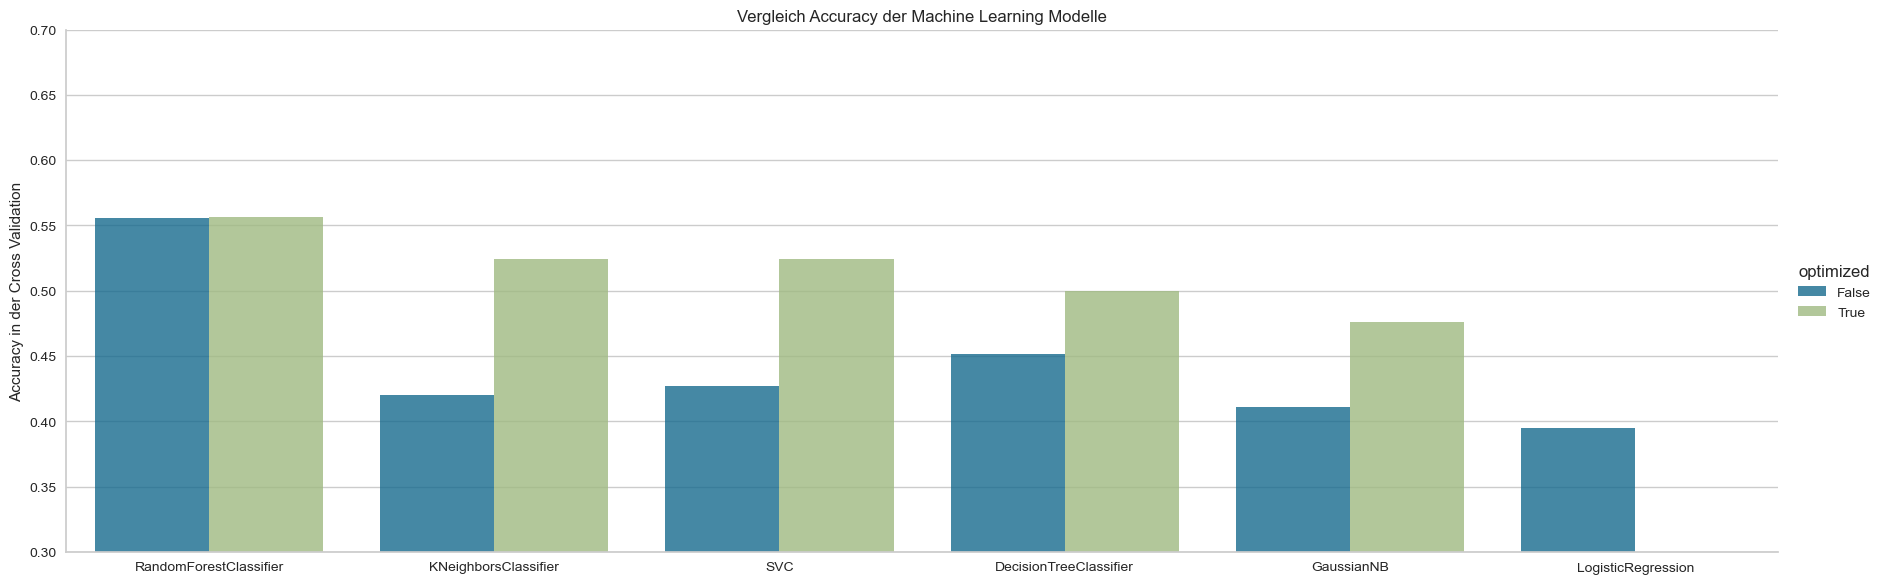

In [200]:
bp = sns.catplot(
    data=df_results.sort_values('accuracy_cv', ascending=False), kind="bar",
    x="modelname", y="accuracy_cv", hue='optimized',
    # ci="std_cv",
    alpha=.8, height=6, aspect=3)
# bp.despine(left=True)
bp.set_axis_labels("", "Accuracy in der Cross Validation")
plt.title("Vergleich Accuracy der Machine Learning Modelle")
plt.ylim([0.3, 0.7])
plt.savefig(f'results/accuracy_comparison_{date.today()}.png')
plt.show()

In [201]:
df_results.to_csv(f'results/results_{date.today()}.csv')

# Evaluierung Feature Engineering

Die Betrachtung der Feature Importance Scores beim Decision Tree und Random Forest (bei anderen Modellen nicht berechenbar) zeigt, dass unsere erstellten Features entweder keine oder nur eine untergeordnete Rolle für die Entscheidung der Modelle spielen.

So ist es anscheinend nicht relevant, ob sicher der Nutzer oder die Nutzerin die Tabellen per Klick anschaut. Für uns überraschend ist es auch nicht wichtig, wie schnell der Bot seine (letzte) Antwort(en) gibt.

Die durchschnittlichen Längen der Prompts und Antworten sind schon wichtiger, allerdings weniger relevant als das Vertrauens in den Bot. 


# Zusammenfassung und Einordnung

Insgesamt lässt sich sagen, dass aufgrund des Datensatzes keine guten Vorhersagen getroffen werden können. Mit User Clustering und Feature Engineering haben wir einiges probiert, um die Vorhersage zu verbessern. Die Performance wurde durch die zusätzlichen generierten Informationen aber tendenziell schlechter. Das einzige wirklich relevante Merkmal scheint das Vertrauen in den Bot zu sein. 

Zum Teil ist die schlechte Performance sicher auch der von uns gewählten Kategorisierung von Valence und Arousal in die 4 Kategorien zu erklären. Die Kategorien sind stark unterschiedlich verteilt, sodass wir die Trainingsdaten erheblich reduzieren müssen. Das führt notwendigerweise zu einer schlechteren Performance des finalen Modells. Zur besseren Generalisierung des Modells ist dieser Schritt aber unbedingt nötig. 